In [6]:
import numpy as np
import pandas as pd

In [7]:
train = pd.read_csv("train_.csv" , low_memory = False , parse_dates = ["order_shipped_date" , "order_delivered_date"])
test = pd.read_csv("test_.csv" , low_memory = False , parse_dates = ["order_shipped_date"])
pins = pd.read_csv("pincodes.csv" , low_memory = False)

In [8]:
# 3) helper to standardize pincode values to digit-only strings

def standardize_pincode_series(s: pd.Series) -> pd.Series:
  s = s.astype(str).str.strip()                            # convert to str + trim whitespace
  s = s.str.extract(r"(\d+)" , expand = False)            # keep first continuous digit-group (handles floats like '421311.0')
  return s

#apply standardization

for df , cols in [(train , ["pickup_pin_code" , "drop_pin_code"]),
                  (test , ["pickup_pin_code" , "drop_pin_code"]),
                  (pins , ["Pincode"])]:
    for c in cols:
        if c in df.columns:
            df[c] = standardize_pincode_series(df[c])
        else:
          print(f"Warning: column '{c}' not found in dataframe; shape={df.shape}")


In [9]:
# 5) deduplicate pincodes: many rows may exist per pincode; reduce to one row per Pincode
#    we keep median latitude/longitude for stability (avoids outliers)

# Convert Latitude and Longitude to numeric, coercing errors to NaN
pins['Latitude'] = pd.to_numeric(pins['Latitude'], errors='coerce')
pins['Longitude'] = pd.to_numeric(pins['Longitude'], errors='coerce')

pins_reduced = pins.groupby("Pincode" , as_index = False).agg({
    "Latitude" : "median" ,
    "Longitude" : "median"
})


# 6) prepare pickup & drop lookup tables
pickup = pins_reduced.rename(columns = {"Pincode" : "pickup_pin_code" ,
                                         "Latitude" : "Pickup_Lat" ,
                                         "Longitude" : "Pickup_Lon"
                                         })[["pickup_pin_code" , "Pickup_Lat" , "Pickup_Lon"]]


drop = pins_reduced.rename(columns = {
    "Pincode" : "drop_pin_code" ,
    "Latitude" : "Drop_Lat" ,
    "Longitude" : "Drop_Lon"
})[["drop_pin_code" , "Drop_Lat" , "Drop_Lon"]]

In [10]:
# 7) merge (left join so we keep all shipments)

train_merged = train.merge(pickup , on = "pickup_pin_code" , how = "left")
train_merged = train_merged.merge(drop , on = "drop_pin_code" , how = "left")

test_merged = test.merge(pickup , on = "pickup_pin_code" , how = "left")
test_merged = test_merged.merge(drop , on = "drop_pin_code" , how = "left")

In [11]:
# 8) report missing lat/lon after merge

summary = {
    "train_rows" : len(train_merged),
    "train_missing_pickup_lat" : int(train_merged["Pickup_Lat"].isna().sum()),
    "train_missing_drop_lat" : int(train_merged["Drop_Lat"].isna().sum()),
    "test_rows" : len(test_merged),
    "test_missing_pickup_lat" : int(test_merged["Pickup_Lat"].isna().sum()),
    "test_missing_drop_lat" : int(test_merged["Drop_Lat"].isna().sum())
}

print("Merge Summary:", summary)

Merge Summary: {'train_rows': 1400831, 'train_missing_pickup_lat': 0, 'train_missing_drop_lat': 11718, 'test_rows': 399845, 'test_missing_pickup_lat': 0, 'test_missing_drop_lat': 3354}


In [12]:
# 9) show up to 50 distinct pincodes from train/test that were not found in pincodes.csv
train_missing_pick_pins = pd.Series(train_merged.loc[train_merged["Pickup_Lat"].isna(), "pickup_pin_code"].dropna().unique()).head(50)
train_missing_drop_pins = pd.Series(train_merged.loc[train_merged["Drop_Lat"].isna(),  "drop_pin_code"].dropna().unique()).head(50)
test_missing_pick_pins  = pd.Series(test_merged.loc[test_merged["Pickup_Lat"].isna(),  "pickup_pin_code"].dropna().unique()).head(50)
test_missing_drop_pins  = pd.Series(test_merged.loc[test_merged["Drop_Lat"].isna(),   "drop_pin_code"].dropna().unique()).head(50)

print("sample missing pickup pincodes (train):", train_missing_pick_pins.tolist())
print("sample missing drop   pincodes (train):", train_missing_drop_pins.tolist())



sample missing pickup pincodes (train): []
sample missing drop   pincodes (train): ['421001', '201308', '743398', '712247', '421003', '302023', '334002', '570024', '227125', '492007', '227107', '313605', '125003', '783121', '229841', '700098', '843351', '843132', '600029', '440009', '832110', '370204', '190016', '600079', '734227', '331002', '392002', '712704', '462032', '400036', '560014', '683582', '382440', '462021', '560039', '205135', '743001', '342004', '798617', '125002', '560069', '362221', '400062', '245412', '734401', '843146', '796002', '560019', '207502', '484552']


In [13]:
# ======= Robust Step-1b (impute + cleanup) =======


# path to pincodes (adjust if needed)
PINS_PATH = "pincodes.csv"

# 1) load & sanitize pincodes
pins = pd.read_csv(PINS_PATH, low_memory=False)
# standardize pincode string
pins["Pincode"] = pins["Pincode"].astype(str).str.strip().str.extract(r"(\d+)", expand=False)
# force lat/lon numeric
pins["Latitude"]  = pd.to_numeric(pins["Latitude"], errors="coerce")
pins["Longitude"] = pd.to_numeric(pins["Longitude"], errors="coerce")

# quick debug print of columns (helps if something unexpected exists)
print("pincodes columns:", pins.columns.tolist())

# 2) detect best state-like column (heuristic)
candidates = [c for c in pins.columns if "state" in c.lower()]  # any column containing 'state'
if not candidates:
    state_col = None
else:
    # pick candidate with the most non-null values (robust)
    counts = {c: pins[c].notna().sum() for c in candidates}
    state_col = max(counts, key=counts.get)
print("Detected state column:", state_col)

# 3) compute global medians (fallback)
global_lat = pins["Latitude"].median()
global_lon = pins["Longitude"].median()
print("Global medians:", global_lat, global_lon)

# 4) build pincode -> state map and state -> median lat/lon maps (if a state column exists)
if state_col:
    # dropna ensures we don't map pincodes to null states
    pincode_state_series = pins.dropna(subset=[state_col]).drop_duplicates(subset=["Pincode"]).set_index("Pincode")[state_col]
    pincode_to_state = pincode_state_series.to_dict()

    # state median lat/lon
    state_medians = pins.dropna(subset=[state_col]).groupby(state_col).agg({"Latitude":"median","Longitude":"median"})
    state_to_lat = state_medians["Latitude"].to_dict()
    state_to_lon = state_medians["Longitude"].to_dict()

    print(f"Built maps: {len(pincode_to_state)} pincodes -> state, {len(state_to_lat)} states -> medians")
else:
    pincode_to_state = {}
    state_to_lat = {}
    state_to_lon = {}

# 5) Map state info into train_merged/test_merged using map (no merges -> avoids duplicates)
#    Assumes train_merged and test_merged already exist in memory from Step-1
train_merged["StateName"] = train_merged["drop_pin_code"].map(pincode_to_state)
test_merged["StateName"]  = test_merged["drop_pin_code"].map(pincode_to_state)

# 6) Map state medians (will produce NaN if StateName is NaN or not present)
train_merged["State_Lat"] = train_merged["StateName"].map(state_to_lat)
train_merged["State_Lon"] = train_merged["StateName"].map(state_to_lon)
test_merged["State_Lat"]  = test_merged["StateName"].map(state_to_lat)
test_merged["State_Lon"]  = test_merged["StateName"].map(state_to_lon)

# 7) create missing flag (before imputation)
train_merged["drop_missing_flag"] = train_merged["Drop_Lat"].isna().astype(int)
test_merged["drop_missing_flag"]  = test_merged["Drop_Lat"].isna().astype(int)

# 8) impute Drop_Lat/Drop_Lon using state medians -> fallback to global medians
train_merged["Drop_Lat"] = train_merged["Drop_Lat"].fillna(train_merged["State_Lat"]).fillna(global_lat)
train_merged["Drop_Lon"] = train_merged["Drop_Lon"].fillna(train_merged["State_Lon"]).fillna(global_lon)
test_merged["Drop_Lat"]  = test_merged["Drop_Lat"].fillna(test_merged["State_Lat"]).fillna(global_lat)
test_merged["Drop_Lon"]  = test_merged["Drop_Lon"].fillna(test_merged["State_Lon"]).fillna(global_lon)

# 9) verify no missing coordinates remain
print("Train missing Drop_Lat after impute:", int(train_merged["Drop_Lat"].isna().sum()))
print("Test  missing Drop_Lat after impute:", int(test_merged["Drop_Lat"].isna().sum()))

# 10) clean columns - keep the essential ones only (train includes target)
cols_to_keep = [
    "id", "order_delivered_date", "courier_partner_id", "order_shipped_date",
    "account_type_id", "drop_pin_code", "pickup_pin_code", "quantity",
    "account_mode", "order_delivery_sla",   # present only in train
    "Pickup_Lat", "Pickup_Lon", "Drop_Lat", "Drop_Lon",
    "drop_missing_flag"
]

train_clean = train_merged[[c for c in cols_to_keep if c in train_merged.columns]].copy()
test_clean  = test_merged[[c for c in cols_to_keep if c in test_merged.columns]].copy()

print("Train clean shape:", train_clean.shape)
print("Test  clean shape:", test_clean.shape)

# 11) save cleaned files
train_clean.to_csv("train_step1_clean.csv", index=False)
test_clean.to_csv("test_step1_clean.csv", index=False)
print("Saved train_step1_clean.csv and test_step1_clean.csv")
# ======= END Step-1b =======


pincodes columns: ['CircleName', 'RegionName', 'DivisionName', 'OfficeName', 'Pincode', 'OfficeType', 'Delivery', 'District', 'StateName', 'Latitude', 'Longitude']
Detected state column: StateName
Global medians: 22.750651 78.51
Built maps: 19300 pincodes -> state, 36 states -> medians
Train missing Drop_Lat after impute: 0
Test  missing Drop_Lat after impute: 0
Train clean shape: (1400831, 15)
Test  clean shape: (399845, 13)
Saved train_step1_clean.csv and test_step1_clean.csv


In [14]:
train = pd.read_csv("train_step1_clean.csv" , parse_dates = ["order_shipped_date" , "order_delivered_date"])
test = pd.read_csv("test_step1_clean.csv" , parse_dates = ["order_shipped_date"])

In [15]:
train.head()

id order_delivered_date  courier_partner_id order_shipped_date  \
0  349197554           2022-06-05                   9         2022-06-02   
1  349197557           2022-06-04                   9         2022-06-02   
2  349197560           2022-06-07                   9         2022-06-02   
3  349197565           2022-06-05                   9         2022-06-02   
4  349197568           2022-06-07                   9         2022-06-02   

   account_type_id  drop_pin_code  pickup_pin_code  quantity account_mode  \
0             2471         141007           421311         1          Air   
1             2471         411047           421311         1          Air   
2             2471         145029           421311         1          Air   
3             2471         751015           562123         1          Air   
4             2471         145029           421311         1          Air   

   order_delivery_sla  Pickup_Lat  Pickup_Lon   Drop_Lat   Drop_Lon  \
0                   3   19.257639   73.074462  30.960000  75.915000   
1                   2   19.257639   73.074462  18.616539  73.942772   
2                   5   19.257639   73.074462  32.390000  75.690000   
3                   3   13.110000   77.360000  20.292333  85.808389   
4                   5   19.257639   73.074462  32.390000  75.690000   

   drop_missing_flag  
0                  0  
1                  0  
2                  0  
3                  0  
4                  0

In [16]:
test.head()

id  courier_partner_id order_shipped_date  account_type_id  \
0  428365149                   3         2022-09-02             2520   
1  428365152                   3         2022-09-02             2520   
2  428365154                   3         2022-09-02             2520   
3  428365156                   3         2022-09-02             2520   
4  428365161                   3         2022-09-02             2520   

   drop_pin_code  pickup_pin_code  quantity account_mode  Pickup_Lat  \
0         243001           122506         1          Air   28.446796   
1         209502           122506         1          Air   28.446796   
2         147001           122506         1          Air   28.446796   
3         245101           122506         1          Air   28.446796   
4         305901           122506         1          Air   28.446796   

   Pickup_Lon   Drop_Lat   Drop_Lon  drop_missing_flag  
0   76.825692  28.355270  79.419900                  0  
1   76.825692  27.551256  79.343696                  0  
2   76.825692  30.336028  76.394597                  0  
3   76.825692  28.717775  77.772386                  0  
4   76.825692  26.100000  74.320000                  0

In [17]:
summary = {
    "train_rows" : len(train),
    "train_missing_pickup_lat" : int(train["Pickup_Lat"].isna().sum()),
    "train_missing_drop_lat" : int(train["Drop_Lat"].isna().sum()),
    "test_rows" : len(test_merged),
    "test_missing_pickup_lat" : int(test["Pickup_Lat"].isna().sum()),
    "test_missing_drop_lat" : int(test["Drop_Lat"].isna().sum())
}

print("Merge Summary:", summary)

Merge Summary: {'train_rows': 1400831, 'train_missing_pickup_lat': 0, 'train_missing_drop_lat': 0, 'test_rows': 399845, 'test_missing_pickup_lat': 0, 'test_missing_drop_lat': 0}


In [18]:
# Haversine distance function
# --------------------------
# =======================================================
# Step-2: Distance Calculation (Improved + Outlier Checks)
# =======================================================


def haversine(lat1, lon1, lat2, lon2):
    """
    Calculate the great-circle distance between two points
    on the Earth specified by latitude and longitude.
    Returns distance in kilometers.
    """
    R = 6371.0  # Earth radius in km

    # convert degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))

    return R * c

# --------------------------
# Apply distance calculation
# --------------------------
train["distance_km"] = haversine(
    train["Pickup_Lat"], train["Pickup_Lon"],
    train["Drop_Lat"],   train["Drop_Lon"]
)

test["distance_km"] = haversine(
    test["Pickup_Lat"], test["Pickup_Lon"],
    test["Drop_Lat"],   test["Drop_Lon"]
)

# --------------------------
# Cap extreme outliers (>3500 km) & check zeros
# --------------------------
train["distance_km"] = train["distance_km"].clip(upper=3500)
test["distance_km"]  = test["distance_km"].clip(upper=3500)

print((train["distance_km"] > 3500).sum(), "rows beyond India max distance (train)")
print((test["distance_km"] > 3500).sum(),  "rows beyond India max distance (test)")
print((train["distance_km"] == 0).sum(), "rows with zero distance (train)")
print((test["distance_km"] == 0).sum(),  "rows with zero distance (test)")
print("NaNs in train distance:", train["distance_km"].isna().sum())
print("NaNs in test distance :", test["distance_km"].isna().sum())

# --------------------------
# Save outputs for Step-3
# --------------------------
train.to_csv("train_step2_distance.csv", index=False)
test.to_csv("test_step2_distance.csv", index=False)

print("✅ Step-2 complete → distance_km added & cleaned")
print("Train shape:", train.shape)
print("Test  shape:", test.shape)
print("Distance stats (train):")
print(train["distance_km"].describe())


0 rows beyond India max distance (train)
0 rows beyond India max distance (test)
450 rows with zero distance (train)
111 rows with zero distance (test)
NaNs in train distance: 0
NaNs in test distance : 0
✅ Step-2 complete → distance_km added & cleaned
Train shape: (1400831, 16)
Test  shape: (399845, 14)
Distance stats (train):
count    1.400831e+06
mean     7.511797e+02
std      6.721019e+02
min      0.000000e+00
25%      2.361993e+02
50%      5.171411e+02
75%      1.218254e+03
max      3.500000e+03
Name: distance_km, dtype: float64


In [19]:
train.head()

id order_delivered_date  courier_partner_id order_shipped_date  \
0  349197554           2022-06-05                   9         2022-06-02   
1  349197557           2022-06-04                   9         2022-06-02   
2  349197560           2022-06-07                   9         2022-06-02   
3  349197565           2022-06-05                   9         2022-06-02   
4  349197568           2022-06-07                   9         2022-06-02   

   account_type_id  drop_pin_code  pickup_pin_code  quantity account_mode  \
0             2471         141007           421311         1          Air   
1             2471         411047           421311         1          Air   
2             2471         145029           421311         1          Air   
3             2471         751015           562123         1          Air   
4             2471         145029           421311         1          Air   

   order_delivery_sla  Pickup_Lat  Pickup_Lon   Drop_Lat   Drop_Lon  \
0                   3   19.257639   73.074462  30.960000  75.915000   
1                   2   19.257639   73.074462  18.616539  73.942772   
2                   5   19.257639   73.074462  32.390000  75.690000   
3                   3   13.110000   77.360000  20.292333  85.808389   
4                   5   19.257639   73.074462  32.390000  75.690000   

   drop_missing_flag  distance_km  
0                  0  1332.125320  
1                  0   115.853888  
2                  0  1483.359704  
3                  0  1202.488035  
4                  0  1483.359704

In [20]:
test.head()

id  courier_partner_id order_shipped_date  account_type_id  \
0  428365149                   3         2022-09-02             2520   
1  428365152                   3         2022-09-02             2520   
2  428365154                   3         2022-09-02             2520   
3  428365156                   3         2022-09-02             2520   
4  428365161                   3         2022-09-02             2520   

   drop_pin_code  pickup_pin_code  quantity account_mode  Pickup_Lat  \
0         243001           122506         1          Air   28.446796   
1         209502           122506         1          Air   28.446796   
2         147001           122506         1          Air   28.446796   
3         245101           122506         1          Air   28.446796   
4         305901           122506         1          Air   28.446796   

   Pickup_Lon   Drop_Lat   Drop_Lon  drop_missing_flag  distance_km  
0   76.825692  28.355270  79.419900                  0   253.942450  
1   76.825692  27.551256  79.343696                  0   266.511524  
2   76.825692  30.336028  76.394597                  0   214.183846  
3   76.825692  28.717775  77.772386                  0    97.225239  
4   76.825692  26.100000  74.320000                  0   359.731771

In [21]:
# STEP 3: Feature engineering (time features, outlier handling, derived features)
# load step2 outputs


train = pd.read_csv("train_step2_distance.csv" , parse_dates = ["order_shipped_date" , "order_delivered_date"] , low_memory = False)
test = pd.read_csv("test_step2_distance.csv" , parse_dates = ["order_shipped_date"] , low_memory = False)

# Ensure numerics

for col in ["distance_km" , "Pickup_Lat" , "Pickup_Lon" , "Drop_Lat" , "Drop_Lon"]:
  train[col] = pd.to_numeric(train[col] , errors = "coerce")
  test[col] = pd.to_numeric(test[col] , errors = "coerce")


# ---------- 1) Verify / compute actual delivery days (train only) ----------

if "order_delivered_date" in train.columns:
  train["actual_delivery_days"] = (train["order_delivered_date"]-train["order_shipped_date"]).dt.days

  # Compare with provided SLA (sanity)

  if "order_delivery_sla" in train.columns:
     mismatch_count = int((train["actual_delivery_days"] != train["order_delivery_sla"]).sum())
     print(f"Label vs dates mismatch rows: {mismatch_count} (out of {len(train)})")
else:
  print("No order_delivered_date int train - skipping actual_delivery_days.")



# ---------- 2) Time-based features (both datasets) ----------

def add_time_feats(df , date_col = "order_shipped_date"):
  df[date_col] = pd.to_datetime(df[date_col] , errors = "coerce")
  df["ship_dow"] = df[date_col].dt.dayofweek         # 0=Mon .. 6=Sun

  # isocalendar().week returns UInt? handle compat
  try:
      df["ship_week"] = df[date_col].dt.isocalendar().week.astype(int)
  except Exception:
    df["ship_week"] = df[date_col].dt.week.astype(int) # Fallback just in case, though isocalendar is preferred
  df["ship_month"] = df[date_col].dt.month
  df["ship_day"] = df[date_col].dt.day
  df["ship_dayofyear"] = df[date_col].dt.dayofyear
  df["is_weekend"] = (df["ship_dow"] >= 5).astype(int) # Fixed 'ship_dow' variable name

  return df


train = add_time_feats(train , "order_shipped_date")
test = add_time_feats(test , "order_shipped_date")


# ---------- 3) Same-location / local flags ----------

train["same_pincode"] = (train["pickup_pin_code"].astype(str) == train["drop_pin_code"].astype(str)).astype(int)
test["same_pincode"] = (test["pickup_pin_code"].astype(str) == test["drop_pin_code"].astype(str)).astype(int)


# local threshold (km) — tweakable

LOCAL_KM = 50
train["is_local"] = (train["distance_km"] <= LOCAL_KM).astype(int)
test["is_local"] = (test["distance_km"] <= LOCAL_KM).astype(int)


# ---------- 4) Quantity & per-item features ----------
# ensure quantity numeric and sensible

train["quantity"] = pd.to_numeric(train["quantity"] , errors = "coerce").fillna(1).astype(int)
test["quantity"] = pd.to_numeric(test["quantity"] , errors = "coerce").fillna(1).astype(int)


# replace zero quantities with 1 to avoid division by zero
train["quantity"] = train["quantity"].replace(0, 1)
test["quantity"]  = test["quantity"].replace(0, 1)

train["distance_per_item"] = train["distance_km"] / train["quantity"]
test["distance_per_item"]  = test["distance_km"] / test["quantity"]



# ---------- 5) Outlier handling & transforms for distance ----------
# compute training percentile for capping

pct = 0.999

p99_9 = float(train["distance_km"].quantile(pct))
print(f"Distance {int(pct*100)}th percentile (train): {p99_9:.2f} km")

# flag outliers (based on train percentile) and cap distances

train["distance_outlier"] = (train["distance_km"] > p99_9).astype(int)
test["distance_outlier"] = (test["distance_km"] > p99_9).astype(int)

# capped distance (useful for models that dislike extreme values)
train["distance_km_capped"] = train["distance_km"].clip(upper = p99_9)
test["distance_km_capped"] = test["distance_km"].clip(upper = p99_9)

# log transforms
train["distance_log1p"] = np.log1p(train["distance_km_capped"])
test["distance_log1p"] = np.log1p(test["distance_km_capped"])


# ---------- 6) Speed proxy (train only) ----------
# prefer actual_delivery_days if available, else use order_delivery_sla, but avoid div-by-zero
EPS = 1.0  # minimum divisor (1 day) to avoid spurious infinity

if "actual_delivery_days" in train.columns:
  denom = train["actual_delivery_days"].clip(lower = 1)  # treat 0-days as 1 day for speed computation
else:
  # fallback to target (if present)
  denom = train["order_delivery_sla"].clip(lower = 1)


train["speed_km_per_day"] = train["distance_km"]/denom


# ---------- 7) Additional small helpful features ----------
# binary flag if distance==0 (same coords)
train["zero_distance"] = (train["distance_km"] == 0).astype(int)
test["zero_distance"]  = (test["distance_km"] == 0).astype(int)

# optional: ratio distance / median distance by courier (group stats, computed on train only)
courier_median = train.groupby("courier_partner_id")["distance_km"].median().to_dict()
train["dist_div_by_courier_median"] = train["distance_km"] / train["courier_partner_id"].map(courier_median).replace({0:np.nan})
test["dist_div_by_courier_median"]  = test["distance_km"]  / test["courier_partner_id"].map(courier_median).replace({0:np.nan})

# ---------- 8) Final checks & save ----------
print("Train features example:")
print(train[["distance_km","distance_km_capped","distance_log1p","distance_outlier","distance_per_item","speed_km_per_day","is_local"]].describe().T)

# Save
train.to_csv("train_step3_features.csv", index=False)
test.to_csv("test_step3_features.csv", index=False)
print("✅ Step-3 complete → saved train_step3_features.csv and test_step3_features.csv")

Label vs dates mismatch rows: 97099 (out of 1400831)
Distance 99th percentile (train): 3500.00 km
Train features example:
                        count        mean         std  min         25%  \
distance_km         1400831.0  751.179658  672.101917  0.0  236.199344   
distance_km_capped  1400831.0  751.179658  672.101917  0.0  236.199344   
distance_log1p      1400831.0    6.039037    1.311519  0.0    5.468901   
distance_outlier    1400831.0    0.000000    0.000000  0.0    0.000000   
distance_per_item   1400831.0  751.179658  672.101917  0.0  236.199344   
speed_km_per_day    1400831.0  320.062769  355.843107  0.0  103.683272   
is_local            1400831.0    0.114780    0.318756  0.0    0.000000   

                           50%          75%          max  
distance_km         517.141054  1218.253911  3500.000000  
distance_km_capped  517.141054  1218.253911  3500.000000  
distance_log1p        6.250248     7.105994     8.160804  
distance_outlier      0.000000     0.000000     0

In [22]:
train.head()

id order_delivered_date  courier_partner_id order_shipped_date  \
0  349197554           2022-06-05                   9         2022-06-02   
1  349197557           2022-06-04                   9         2022-06-02   
2  349197560           2022-06-07                   9         2022-06-02   
3  349197565           2022-06-05                   9         2022-06-02   
4  349197568           2022-06-07                   9         2022-06-02   

   account_type_id  drop_pin_code  pickup_pin_code  quantity account_mode  \
0             2471         141007           421311         1          Air   
1             2471         411047           421311         1          Air   
2             2471         145029           421311         1          Air   
3             2471         751015           562123         1          Air   
4             2471         145029           421311         1          Air   

   order_delivery_sla  ...  is_weekend  same_pincode  is_local  \
0                   3  ...           0             0         0   
1                   2  ...           0             0         0   
2                   5  ...           0             0         0   
3                   3  ...           0             0         0   
4                   5  ...           0             0         0   

   distance_per_item  distance_outlier  distance_km_capped  distance_log1p  \
0        1332.125320                 0         1332.125320        7.195281   
1         115.853888                 0          115.853888        4.760924   
2        1483.359704                 0         1483.359704        7.302739   
3        1202.488035                 0         1202.488035        7.092979   
4        1483.359704                 0         1483.359704        7.302739   

   speed_km_per_day  zero_distance  dist_div_by_courier_median  
0        444.041773              0                    1.196547  
1         57.926944              0                    0.104063  
2        296.671941              0                    1.332390  
3        400.829345              0                    1.080104  
4        296.671941              0                    1.332390  

[5 rows x 32 columns]

In [23]:
# ============================================================
# STEP 4 — Preprocessing & Encoding (ready for modeling)
# ============================================================


# -----------------------------
# 1) Load the Step-3 datasets
# -----------------------------
train = pd.read_csv("train_step3_features.csv",
                    parse_dates=["order_shipped_date","order_delivered_date"],
                    low_memory=False)
test  = pd.read_csv("test_step3_features.csv",
                    parse_dates=["order_shipped_date"],
                    low_memory=False)

# -----------------------------
# 2) Sanity: target distribution
# -----------------------------
target_col = "order_delivery_sla"
if target_col in train.columns:
    print("Target distribution (SLA days):")
    print(train[target_col].value_counts(dropna=False).sort_index())
else:
    raise ValueError("Target column 'order_delivery_sla' not found in train.")

# -----------------------------
# 3) Categorical encodings
#    - Label-encode small/medium-cardinality cats
#    - Frequency-encode high-cardinality pincodes
# -----------------------------
label_cats = ["courier_partner_id", "account_type_id", "account_mode"]  # treat IDs as categories
high_card_pins = ["pickup_pin_code", "drop_pin_code"]                   # very high cardinality

# Helper: label-encode using pd.Categorical with train categories, unseen → -1
def fit_apply_label_encoding(train_series, test_series):
    cats = pd.Categorical(train_series.astype(str))  # categories from train
    categories = list(cats.categories)               # fixed category list

    tr_enc = pd.Categorical(train_series.astype(str), categories=categories).codes
    te_enc = pd.Categorical(test_series.astype(str),  categories=categories).codes

    # Fix: replace -1 (unseen categories in test) with new code = max+1
    tr_enc = np.where(tr_enc == -1, len(categories), tr_enc)
    te_enc = np.where(te_enc == -1, len(categories), te_enc)

    return tr_enc.astype("int32"), te_enc.astype("int32"), categories


label_encoders = {}
for col in label_cats:
    if col not in train.columns:
        continue
    tr_enc, te_enc, cats = fit_apply_label_encoding(train[col], test[col] if col in test.columns else pd.Series(["NA"]*len(test)))
    train[col + "_le"] = tr_enc
    test[col + "_le"]  = te_enc
    label_encoders[col] = cats  # keep for reference
    # (We keep the original col for now; we'll drop it before modeling)

# Frequency encoding for pincodes (use TRAIN frequencies to avoid leakage)
for col in high_card_pins:
    if col in train.columns:
        # proportions (0..1) are safer than raw counts
        freq = (train[col].astype(str).value_counts() / len(train))
        train[col + "_freq"] = train[col].astype(str).map(freq).fillna(0.0).astype("float32")
        # apply same mapping to test; unseen → 0.0
        test[col + "_freq"]  = test[col].astype(str).map(freq).fillna(0.0).astype("float32")

# Optional: route pair frequency (pickup, drop) — very predictive
if all(c in train.columns for c in high_card_pins):
    route = train[high_card_pins[0]].astype(str) + "→" + train[high_card_pins[1]].astype(str)
    route_freq = (route.value_counts() / len(train))
    train["route_freq"] = route.map(route_freq).astype("float32")
    route_te = test[high_card_pins[0]].astype(str) + "→" + test[high_card_pins[1]].astype(str)
    test["route_freq"] = route_te.map(route_freq).fillna(0.0).astype("float32")

# -----------------------------------------
# 4) Choose features and drop raw strings
# -----------------------------------------
drop_cols_common = [
    "order_shipped_date", "order_delivered_date",   # datetimes (we already extracted time features)
    "account_mode",                                  # raw text; we keep account_mode_le
    "pickup_pin_code", "drop_pin_code"               # raw ids; we keep *_freq (and route_freq)
]

# Some files may not have all of these; drop-if-exists
train = train.drop(columns=[c for c in drop_cols_common if c in train.columns])
test  = test.drop(columns=[c for c in drop_cols_common if c in test.columns])

# -----------------------------------------
# 5) Train/Validation time-based split
#    - use last 20% of shipped dates as validation
# -----------------------------------------
VAL_FRAC = 0.20
# Use ship_dayofyear for splitting as order_shipped_date is dropped
cutoff_dayofyear = train["ship_dayofyear"].quantile(1 - VAL_FRAC)
mask_val = train["ship_dayofyear"] >= cutoff_dayofyear

train_tr = train.loc[~mask_val].copy()
train_va = train.loc[ mask_val].copy()

print(f"Time-based split: cutoff dayofyear = {cutoff_dayofyear:.0f} "
      f"→ train rows={len(train_tr)}, val rows={len(train_va)}")

# -----------------------------------------
# 6) Build final feature list
#    - everything numeric except id and target
# -----------------------------------------
id_col = "id"

def feature_cols(df, target_ok=True):
    cols = df.select_dtypes(include=[np.number, "bool"]).columns.tolist()
    # remove id and (optionally) target
    if id_col in cols: cols.remove(id_col)
    if target_ok and target_col in cols: cols.remove(target_col)
    return cols

X_tr_cols = feature_cols(train_tr, target_ok=True)
X_va_cols = feature_cols(train_va, target_ok=True)
X_te_cols = feature_cols(test,     target_ok=True)  # test has no target

# Ensure column alignment across train/val/test
# (take intersection to be safe; or enforce train columns on all)
common_cols = sorted(list(set(X_tr_cols) & set(X_va_cols) & set(X_te_cols)))
X_tr = train_tr[common_cols].copy()
X_va = train_va[common_cols].copy()
X_te = test[common_cols].copy()

y_tr = train_tr[target_col].copy()
y_va = train_va[target_col].copy()

print(f"Number of features: {len(common_cols)}")

# -----------------------------------------
# 7) Numeric imputation (median from TRAIN)
# -----------------------------------------
num_cols = X_tr.select_dtypes(include=[np.number, "bool"]).columns.tolist()
medians = {c: X_tr[c].median() for c in num_cols}

for c in num_cols:
    X_tr[c] = X_tr[c].fillna(medians[c])
    X_va[c] = X_va[c].fillna(medians[c])
    X_te[c] = X_te[c].fillna(medians[c])

# -----------------------------------------
# 8) Save “ready-to-model” files
# -----------------------------------------
train_ready = pd.concat([train_tr[[id_col, target_col]].reset_index(drop=True),
                         X_tr.reset_index(drop=True)], axis=1)
val_ready   = pd.concat([train_va[[id_col, target_col]].reset_index(drop=True),
                         X_va.reset_index(drop=True)], axis=1)
test_ready  = pd.concat([test[[id_col]].reset_index(drop=True),
                         X_te.reset_index(drop=True)], axis=1)

train_ready.to_csv("train_step4_ready.csv", index=False)
val_ready.to_csv("val_step4_ready.csv", index=False)
test_ready.to_csv("test_step4_ready.csv", index=False)

print("✅ Step-4 complete →")
print("  - train_step4_ready.csv:", train_ready.shape)
print("  - val_step4_ready.csv:  ", val_ready.shape)
print("  - test_step4_ready.csv: ", test_ready.shape)
print("Feature columns:")
print(common_cols)

Target distribution (SLA days):
order_delivery_sla
-1          1
 0     131444
 1     192940
 2     453467
 3     295809
 4     167003
 5      81774
 6      36327
 7      17433
 8       9672
 9       5362
 10      3128
 11      1968
 12      1119
 13       751
 14       485
 15       427
 16       281
 17       227
 18       423
 19       168
 20       130
 21        98
 22        65
 23        38
 24        31
 25        15
 26        24
 27        37
 28        35
 29        63
 30        14
 31        12
 32         4
 33        11
 34        17
 35         2
 36         1
 39         2
 40         3
 41         1
 45         1
 46         1
 48         2
 50         1
 51         2
 52         1
 53         1
 54         1
 56         1
 61         1
 63         2
 84         2
 88         2
 91         1
Name: count, dtype: int64
Time-based split: cutoff dayofyear = 226 → train rows=1115514, val rows=285317
Number of features: 29
✅ Step-4 complete →
  - train_step4_ready.csv: (111

In [24]:
# =====================================================
# STEP 4B → Exploratory Data Visualization
# =====================================================
import matplotlib.pyplot as plt
import seaborn as sns

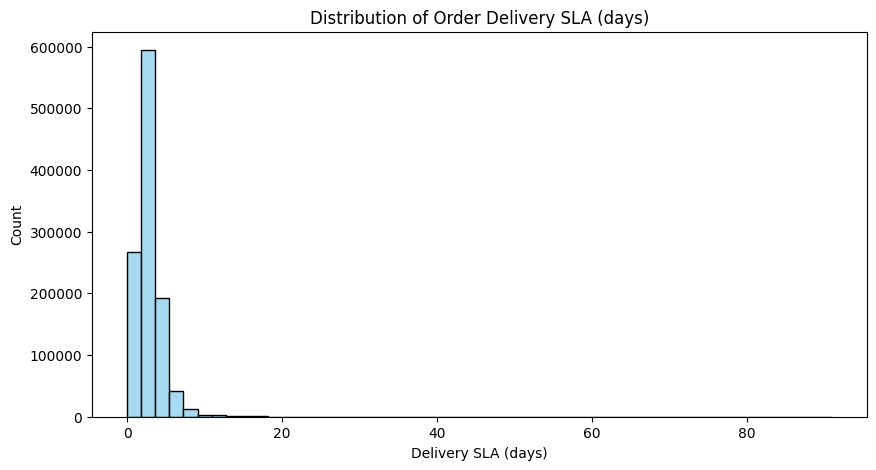

In [25]:
# Load preprocessed data
train = pd.read_csv("train_step4_ready.csv")

# --------------------------
# 1) Target distribution
# --------------------------
plt.figure(figsize=(10, 5))
sns.histplot(train["order_delivery_sla"], bins=50, kde=False, color="skyblue")
plt.title("Distribution of Order Delivery SLA (days)")
plt.xlabel("Delivery SLA (days)")
plt.ylabel("Count")
plt.show()

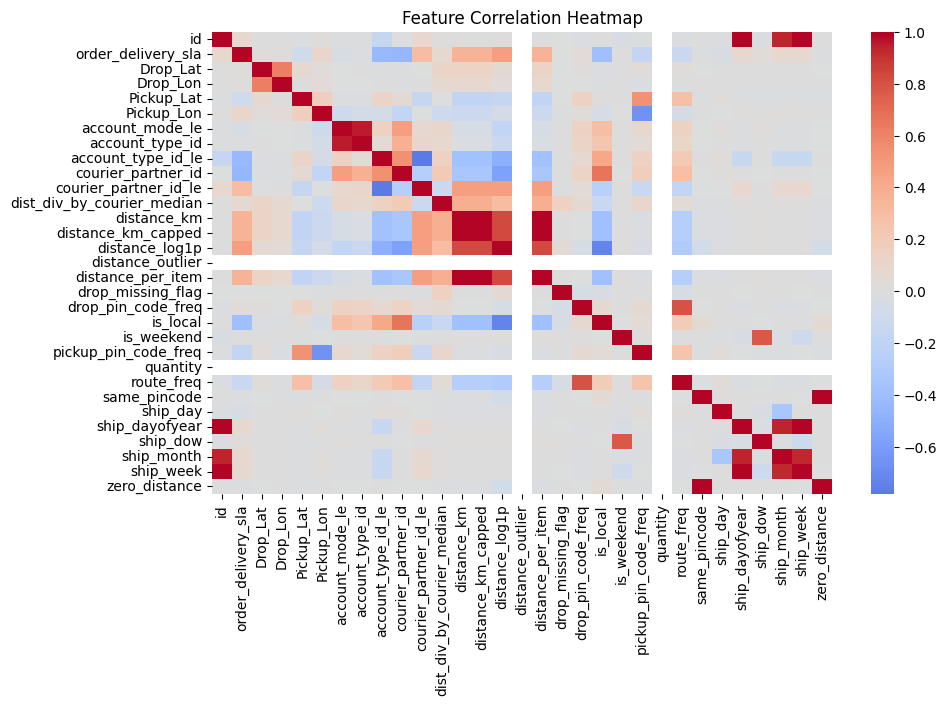

In [26]:
# --------------------------
# 2) Correlation heatmap
# --------------------------
plt.figure(figsize=(10, 6))
corr = train.corr(numeric_only=True)
sns.heatmap(corr, cmap="coolwarm", center=0, annot=False)
plt.title("Feature Correlation Heatmap")
plt.show()

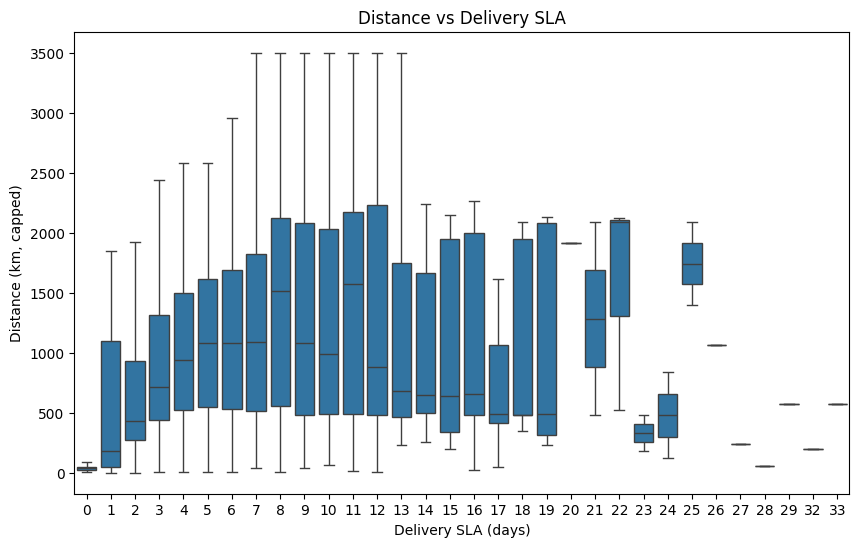

In [27]:
# --------------------------
# 3) Feature vs SLA
# --------------------------

# distance vs SLA
plt.figure(figsize=(10, 6))
sns.boxplot(x="order_delivery_sla", y="distance_km_capped", data=train.sample(50000), showfliers=False)
plt.title("Distance vs Delivery SLA")
plt.xlabel("Delivery SLA (days)")
plt.ylabel("Distance (km, capped)")
plt.show()


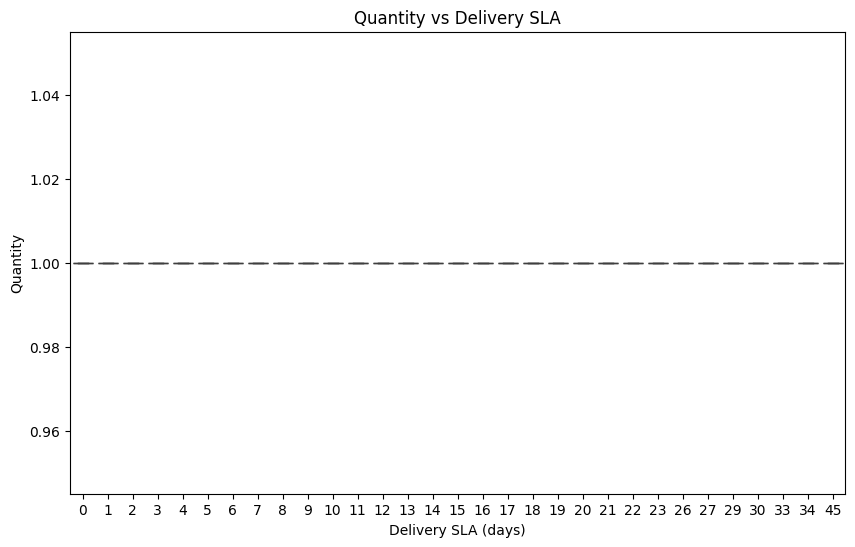

In [28]:
# quantity vs SLA
plt.figure(figsize=(10, 6))
sns.boxplot(x="order_delivery_sla", y="quantity", data=train.sample(50000), showfliers=False)
plt.title("Quantity vs Delivery SLA")
plt.xlabel("Delivery SLA (days)")
plt.ylabel("Quantity")
plt.show()

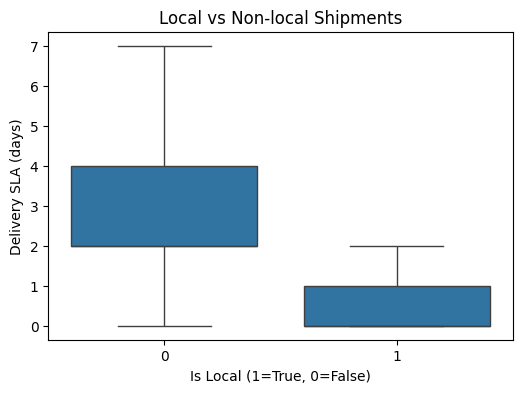

✅ Step-4B complete → Visualization ready for analysis.


In [29]:
# is_local vs SLA
plt.figure(figsize=(6, 4))
sns.boxplot(x="is_local", y="order_delivery_sla", data=train.sample(50000), showfliers=False)
plt.title("Local vs Non-local Shipments")
plt.xlabel("Is Local (1=True, 0=False)")
plt.ylabel("Delivery SLA (days)")
plt.show()

print("✅ Step-4B complete → Visualization ready for analysis.")

<Axes: xlabel='order_delivery_sla', ylabel='distance_log1p'>

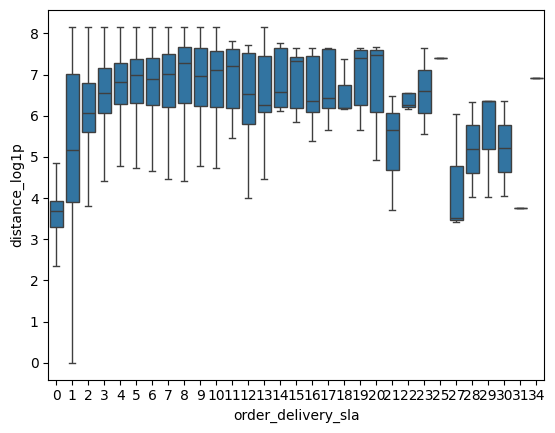

In [30]:
sns.boxplot(x="order_delivery_sla", y="distance_log1p", data=train.sample(50000), showfliers=False)


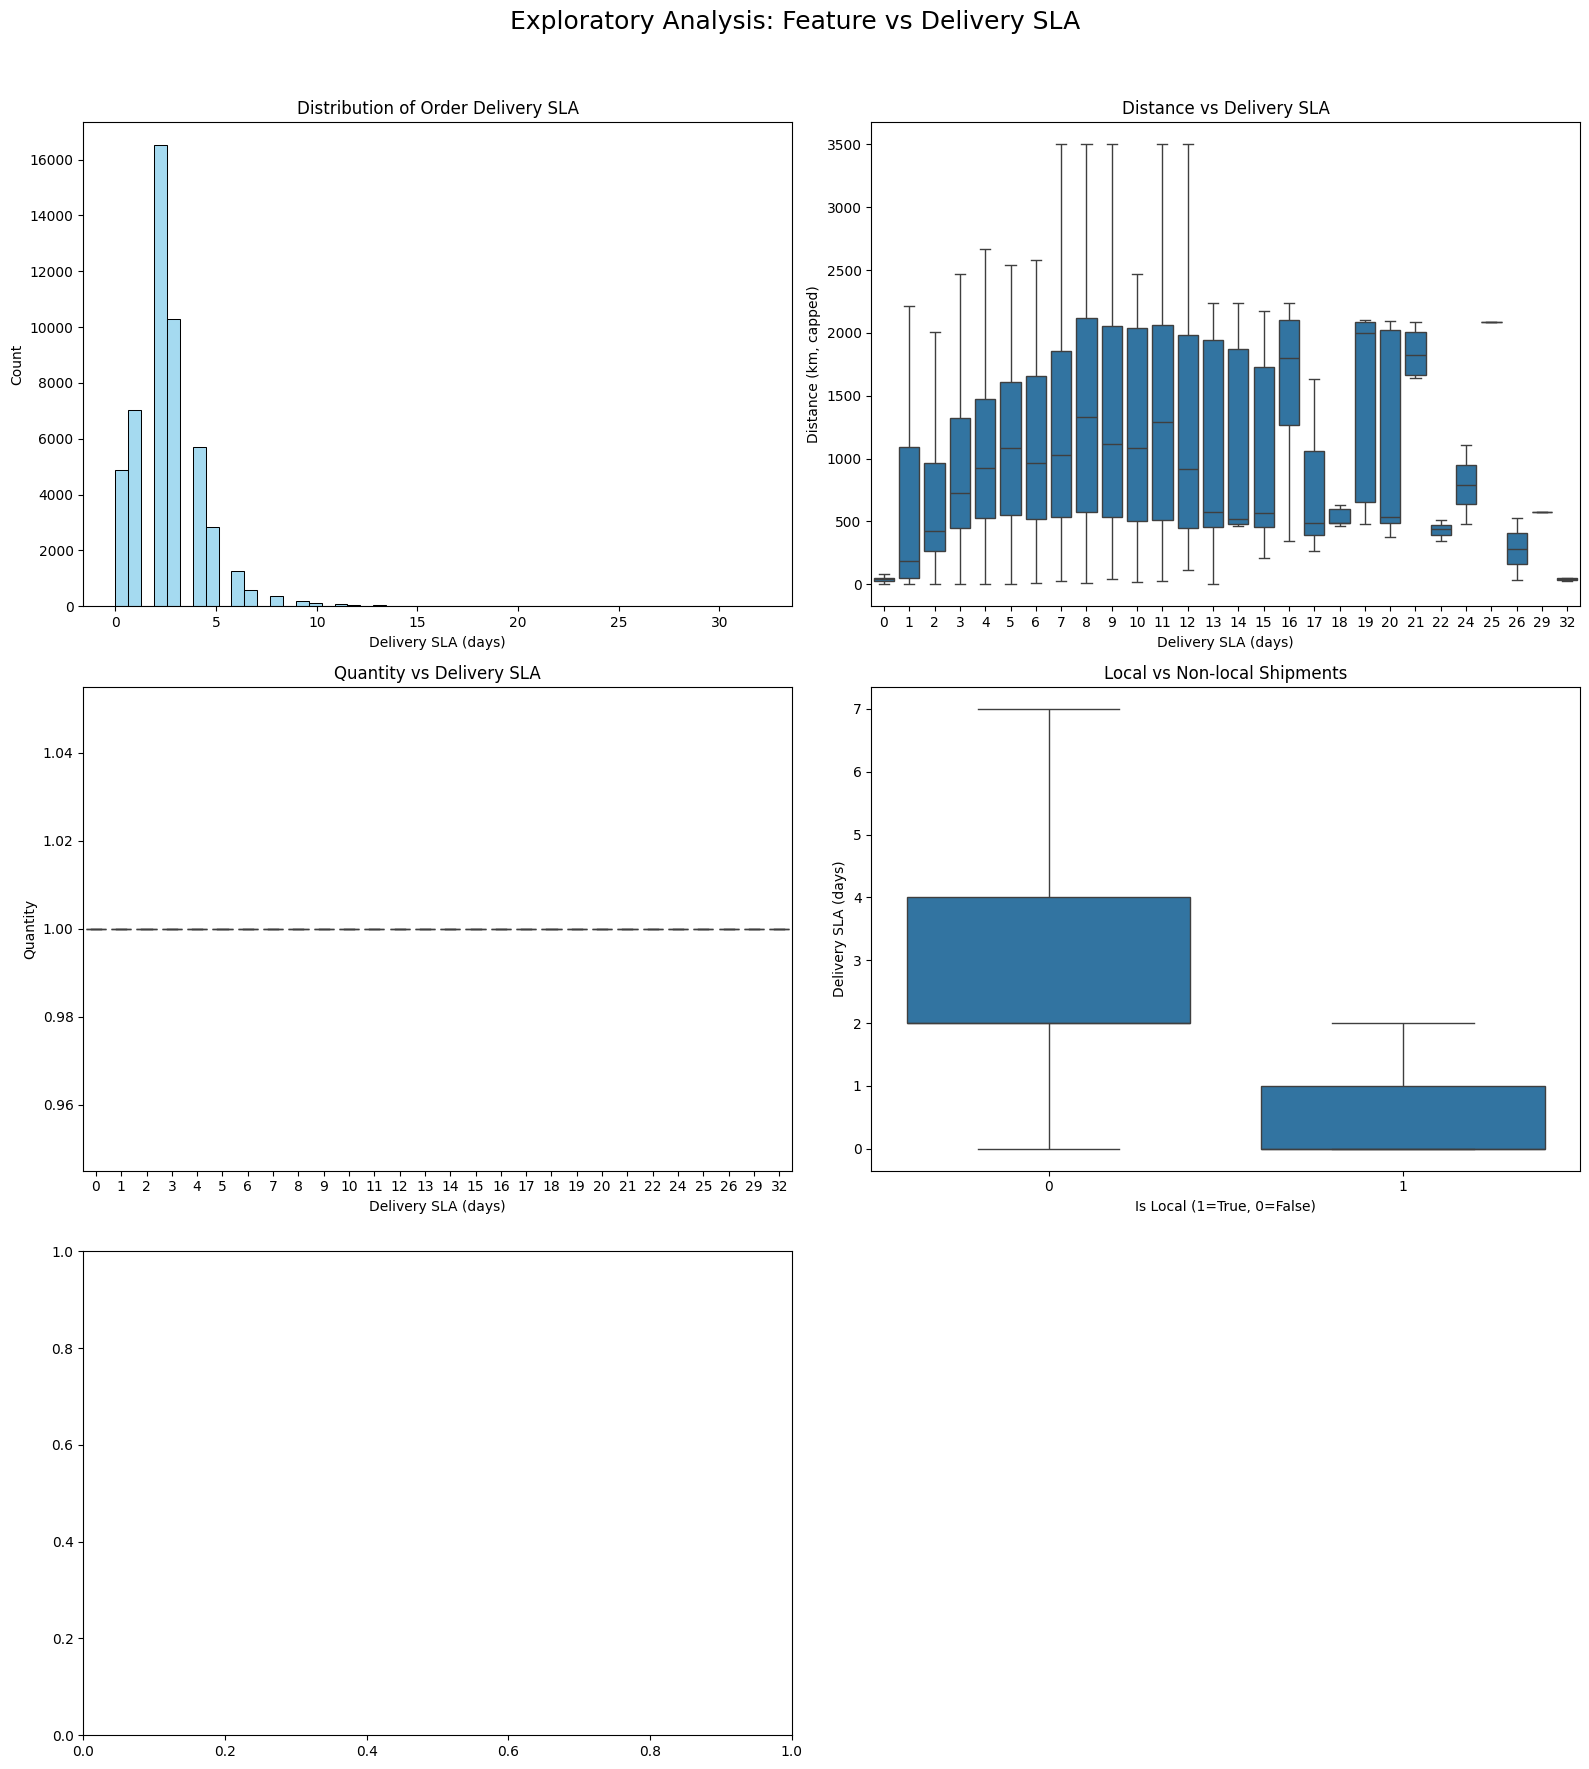

In [31]:


# Load preprocessed data
train = pd.read_csv("train_step4_ready.csv")

# Sample for faster plotting
sample_df = train.sample(50000, random_state=42)

# Set up figure with subplots
fig, axes = plt.subplots(3, 2, figsize=(16, 18))
fig.suptitle("Exploratory Analysis: Feature vs Delivery SLA", fontsize=18)

# -----------------------------
# 1) Target distribution
sns.histplot(sample_df["order_delivery_sla"], bins=50, kde=False, color="skyblue", ax=axes[0,0])
axes[0,0].set_title("Distribution of Order Delivery SLA")
axes[0,0].set_xlabel("Delivery SLA (days)")
axes[0,0].set_ylabel("Count")

# -----------------------------
# 2) Distance vs SLA
sns.boxplot(x="order_delivery_sla", y="distance_km_capped", data=sample_df, showfliers=False, ax=axes[0,1])
axes[0,1].set_title("Distance vs Delivery SLA")
axes[0,1].set_xlabel("Delivery SLA (days)")
axes[0,1].set_ylabel("Distance (km, capped)")

# -----------------------------
# 3) Quantity vs SLA
sns.boxplot(x="order_delivery_sla", y="quantity", data=sample_df, showfliers=False, ax=axes[1,0])
axes[1,0].set_title("Quantity vs Delivery SLA")
axes[1,0].set_xlabel("Delivery SLA (days)")
axes[1,0].set_ylabel("Quantity")

# -----------------------------
# 4) is_local vs SLA
sns.boxplot(x="is_local", y="order_delivery_sla", data=sample_df, showfliers=False, ax=axes[1,1])
axes[1,1].set_title("Local vs Non-local Shipments")
axes[1,1].set_xlabel("Is Local (1=True, 0=False)")
axes[1,1].set_ylabel("Delivery SLA (days)")


# -----------------------------
# 6) Optional: hide unused subplot
axes[2,1].axis('off')

# -----------------------------
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [32]:
# --------------------------
# Step 5a: Linear Regression baseline
# --------------------------

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 1) Load preprocessed train/val data
train = pd.read_csv("train_step4_ready.csv")
val   = pd.read_csv("val_step4_ready.csv")

# 2) Define target and features
target_col = "order_delivery_sla"
id_col = "id"

X_train = train.drop(columns=[target_col, id_col])
y_train = train[target_col]

X_val = val.drop(columns=[target_col, id_col])
y_val = val[target_col]

print(f"Train shape: {X_train.shape}, Val shape: {X_val.shape}")

# 3) Train Linear Regression model
lr = LinearRegression()
lr.fit(X_train, y_train)

# 4) Predictions
val_preds = lr.predict(X_val)

# 5) Evaluation metrics
rmse = np.sqrt(mean_squared_error(y_val, val_preds))
mae  = mean_absolute_error(y_val, val_preds)

print("📊 Linear Regression Results:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE : {mae:.4f}")

Train shape: (1115514, 29), Val shape: (285317, 29)
📊 Linear Regression Results:
RMSE: 1.3520
MAE : 0.9621


In [33]:
# --------------------------
# Step 5b: Decision Tree Regressor
# --------------------------

from sklearn.tree import DecisionTreeRegressor

# Train model
dt = DecisionTreeRegressor(
    max_depth=12,       # limit depth to avoid overfitting
    min_samples_split=100,
    random_state=42
)
dt.fit(X_train, y_train)

# Predictions
val_preds_dt = dt.predict(X_val)

# Evaluation
rmse_dt = np.sqrt(mean_squared_error(y_val, val_preds_dt))
mae_dt  = mean_absolute_error(y_val, val_preds_dt)

print("🌳 Decision Tree Results:")
print(f"RMSE: {rmse_dt:.4f}")
print(f"MAE : {mae_dt:.4f}")


🌳 Decision Tree Results:
RMSE: 1.3301
MAE : 0.7884


In [34]:
# --------------------------
# Step 5c: Random Forest Regressor
# --------------------------

from sklearn.ensemble import RandomForestRegressor

# Train model
rf = RandomForestRegressor(
    n_estimators=100,    # number of trees
    max_depth=15,        # limit depth
    n_jobs=-1,           # use all CPU cores
    random_state=42
)
rf.fit(X_train, y_train)

# Predictions
val_preds_rf = rf.predict(X_val)

# Evaluation
rmse_rf = np.sqrt(mean_squared_error(y_val, val_preds_rf))
mae_rf  = mean_absolute_error(y_val, val_preds_rf)

print("🌲 Random Forest Results:")
print(f"RMSE: {rmse_rf:.4f}")
print(f"MAE : {mae_rf:.4f}")


🌲 Random Forest Results:
RMSE: 1.2130
MAE : 0.7729


In [35]:
# --------------------------
# Step 5c: Random Forest Regressor
# --------------------------

from sklearn.ensemble import RandomForestRegressor

# Train model
rf = RandomForestRegressor(
    n_estimators=50,    # number of trees
    max_depth=15,        # limit depth
    n_jobs=-1,           # use all CPU cores
    random_state=42
)
rf.fit(X_train, y_train)

# Predictions
val_preds_rf = rf.predict(X_val)

# Evaluation
rmse_rf = np.sqrt(mean_squared_error(y_val, val_preds_rf))
mae_rf  = mean_absolute_error(y_val, val_preds_rf)

print("🌲 Random Forest Results:")
print(f"RMSE: {rmse_rf:.4f}")
print(f"MAE : {mae_rf:.4f}")


🌲 Random Forest Results:
RMSE: 1.2063
MAE : 0.7721


In [36]:
# --------------------------
# Step 5d: LightGBM Regressor (fixed)
# --------------------------
import lightgbm as lgb

# Prepare datasets
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_val   = lgb.Dataset(X_val, label=y_val, reference=lgb_train)

# Parameters
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,
    'num_leaves': 64,
    'max_depth': -1,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'seed': 42
}

# Train with callbacks
model_lgb = lgb.train(
    params,
    lgb_train,
    num_boost_round=500,
    valid_sets=[lgb_train, lgb_val],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=50)  # print every 50 rounds
    ]
)

# Predictions
val_preds_lgb = model_lgb.predict(X_val, num_iteration=model_lgb.best_iteration)

# Evaluation
rmse_lgb = np.sqrt(mean_squared_error(y_val, val_preds_lgb))
mae_lgb  = mean_absolute_error(y_val, val_preds_lgb)

print("🚀 LightGBM Results:")
print(f"RMSE: {rmse_lgb:.4f}")
print(f"MAE : {mae_lgb:.4f}")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.302883 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2484
[LightGBM] [Info] Number of data points in the train set: 1115514, number of used features: 27
[LightGBM] [Info] Start training from score 2.581122
Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 1.14415	valid_1's rmse: 1.09273
Early stopping, best iteration is:
[34]	training's rmse: 1.16887	valid_1's rmse: 1.08983
🚀 LightGBM Results:
RMSE: 1.0898
MAE : 0.7449


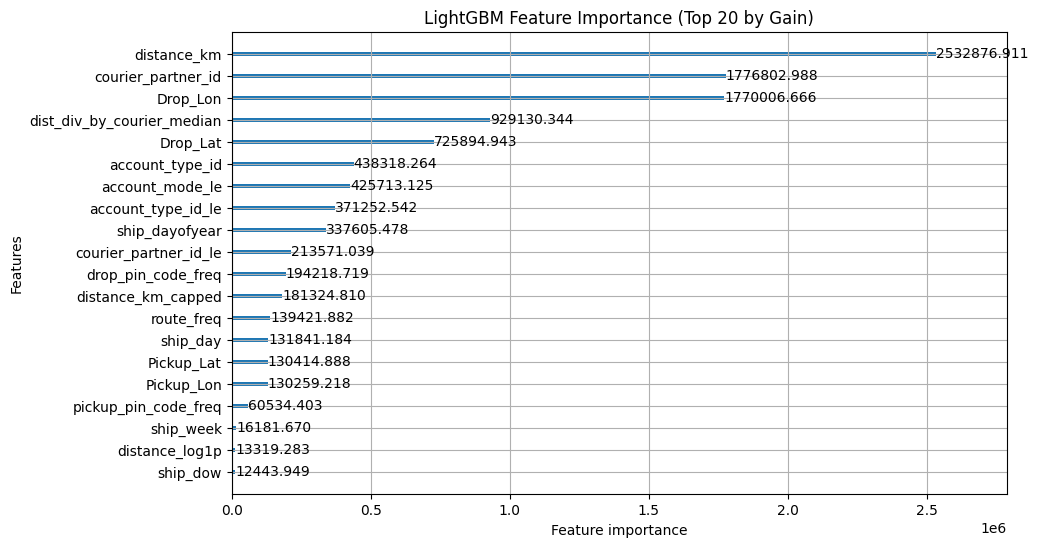

In [37]:
lgb.plot_importance(model_lgb, max_num_features=20, importance_type="gain", figsize=(10,6))
plt.title("LightGBM Feature Importance (Top 20 by Gain)")
plt.show()

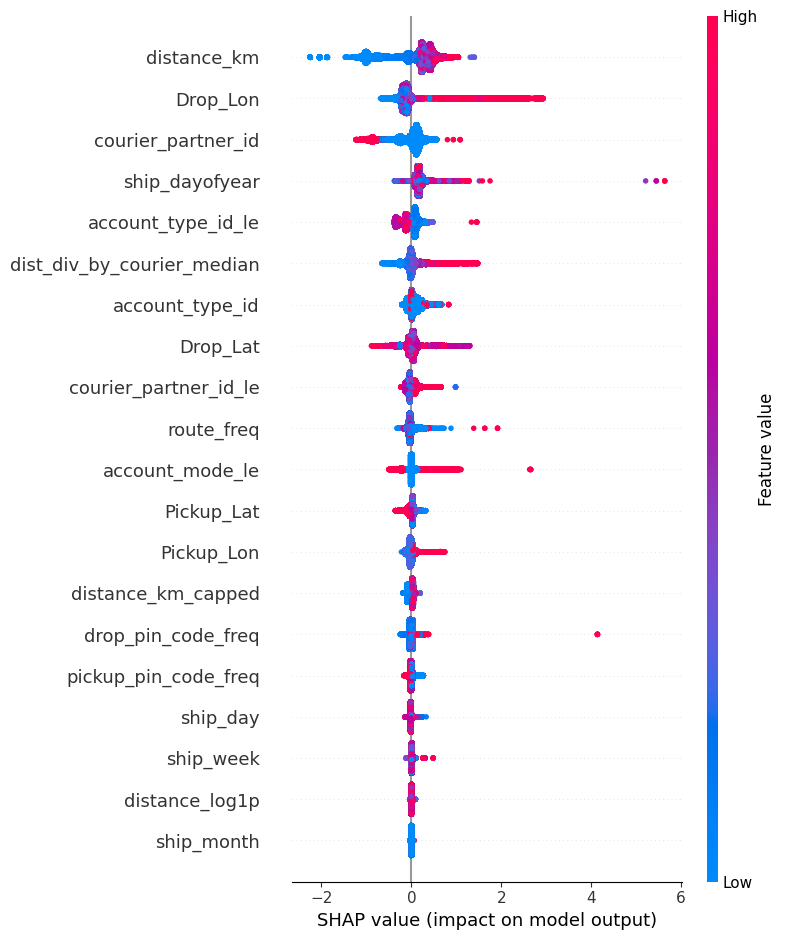

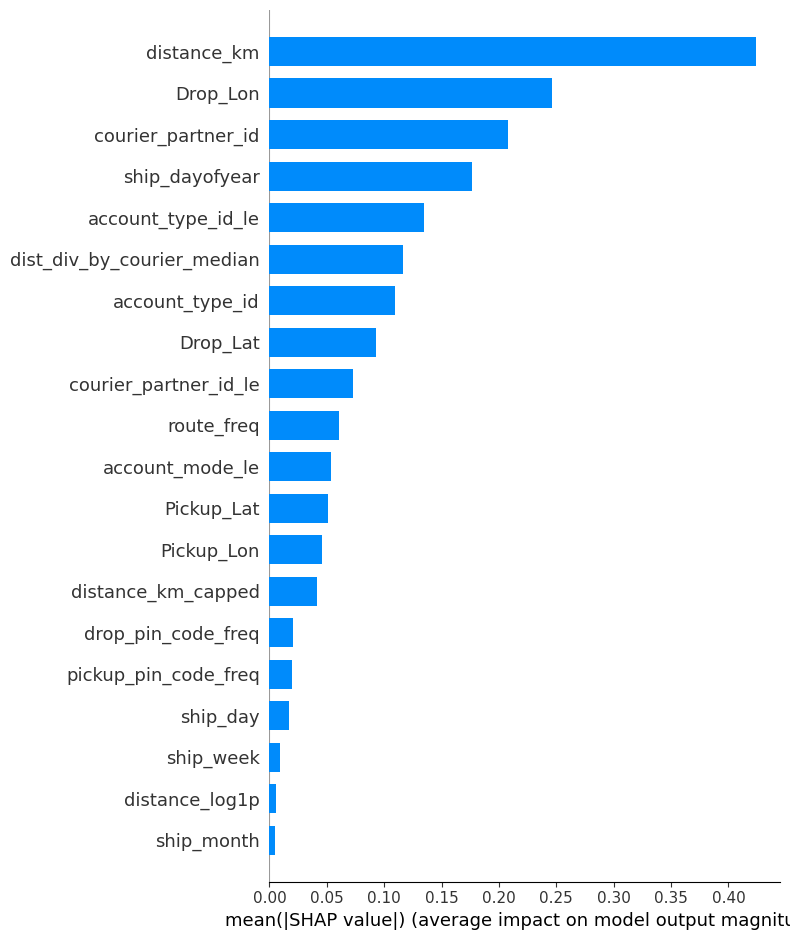

In [38]:
import shap

shap.initjs()


# 1) Initialize TreeExplainer for LightGBM
explainer = shap.TreeExplainer(model_lgb)

# 2) Compute SHAP values for validation set
shap_values = explainer(X_val)

# 3a) Summary plot (global importance + direction)
shap.summary_plot(shap_values, X_val, plot_type="dot")

# 3b) Bar plot (global mean absolute importance)
shap.summary_plot(shap_values, X_val, plot_type="bar")

# 3c) Force plot (local explanation for a single prediction)
i = 0  # index of row to explain
shap.plots.force(explainer.expected_value, shap_values[i].values, X_val.iloc[i])


In [39]:
# =========================
# XGBoost (robust train API)
# =========================
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Load preprocessed train/val (or reuse variables if already in memory)
train = pd.read_csv("train_step4_ready.csv")
val   = pd.read_csv("val_step4_ready.csv")

# features = all columns except id and target
target = "order_delivery_sla"
features = [c for c in train.columns if c not in ["id", target]]

X_train, y_train = train[features], train[target]
X_val,   y_val   = val[features],   val[target]

# Create DMatrix (XGBoost's optimized data structure)
dtrain = xgb.DMatrix(X_train, label=y_train)
dval   = xgb.DMatrix(X_val,   label=y_val)

# Params (tweakable)
params = {
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "eta": 0.1,               # learning rate
    "max_depth": 8,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "lambda": 1.0,           # L2 regularization
    "seed": 42,
    "verbosity": 1
}

# Train with early stopping (max 500 rounds, stop after 50 rounds w/o improvement)
evals = [(dtrain, "train"), (dval, "val")]
bst = xgb.train(
    params,
    dtrain,
    num_boost_round=500,
    evals=evals,
    early_stopping_rounds=50,
    verbose_eval=50
)

# Predict using the best number of trees
if hasattr(bst, "best_ntree_limit") and bst.best_ntree_limit is not None:
    best_ntrees = bst.best_ntree_limit
elif hasattr(bst, "best_iteration") and bst.best_iteration is not None:
    best_ntrees = bst.best_iteration + 1
else:
    best_ntrees = None

if best_ntrees:
    # For xgboost>=2.0 use iteration_range
    val_preds_xgb = bst.predict(dval, iteration_range=(0, best_ntrees))
else:
    val_preds_xgb = bst.predict(dval)

# Evaluate
rmse_xgb = np.sqrt(mean_squared_error(y_val, val_preds_xgb)) # Removed squared=False and took square root
mae_xgb  = mean_absolute_error(y_val, val_preds_xgb)

print("🔥 XGBoost Results:")
print(f"Best iteration (trees): {best_ntrees}")
print(f"RMSE: {rmse_xgb:.4f}")
print(f"MAE : {mae_xgb:.4f}")

[0]	train-rmse:1.80072	val-rmse:1.63503
[50]	train-rmse:1.10659	val-rmse:1.11871
[100]	train-rmse:1.06642	val-rmse:1.12047
[118]	train-rmse:1.05710	val-rmse:1.12187
🔥 XGBoost Results:
Best iteration (trees): 70
RMSE: 1.1174
MAE : 0.7396


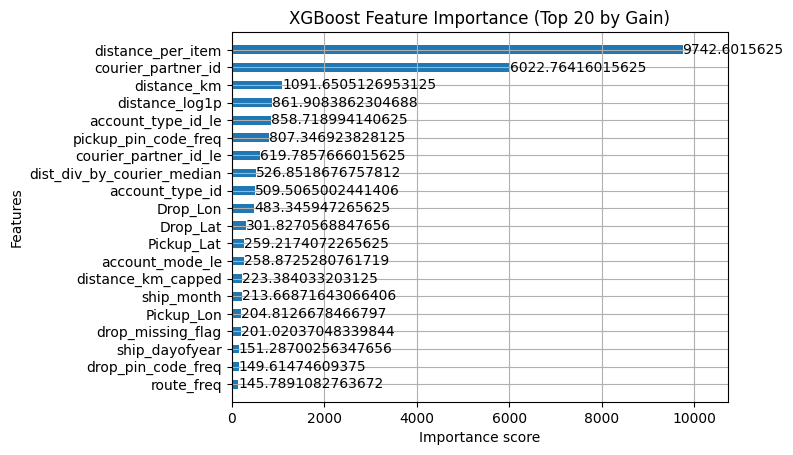

In [40]:
import matplotlib.pyplot as plt
import xgboost as xgb

# Plot feature importance
xgb.plot_importance(bst, importance_type="gain", max_num_features=20, height=0.5)
plt.title("XGBoost Feature Importance (Top 20 by Gain)")
plt.show()


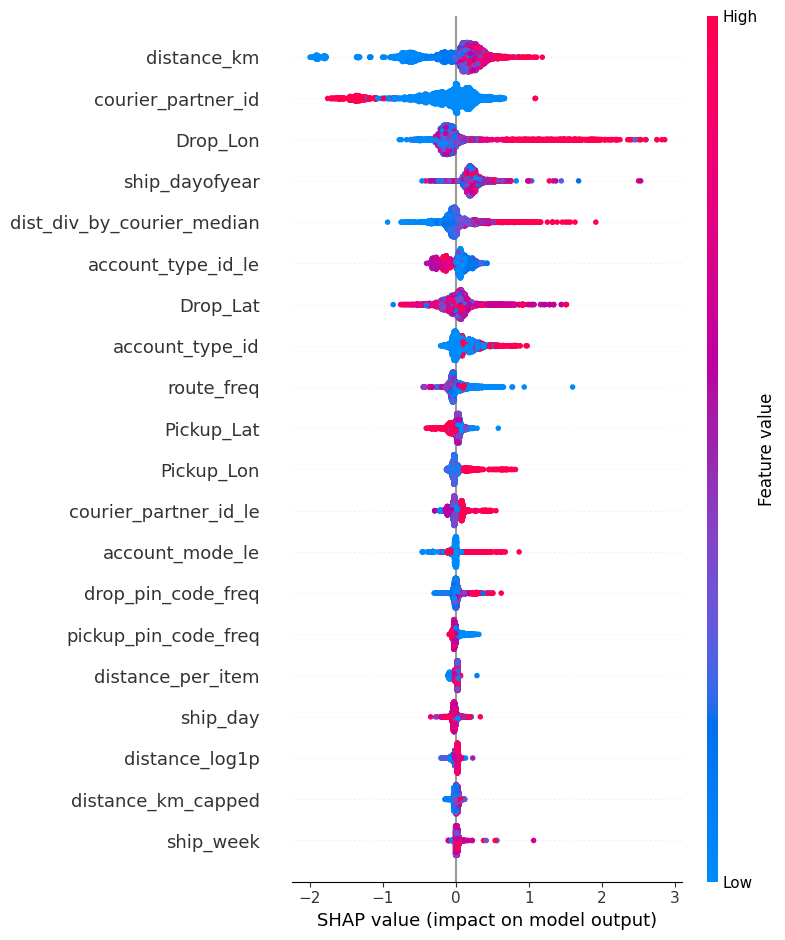

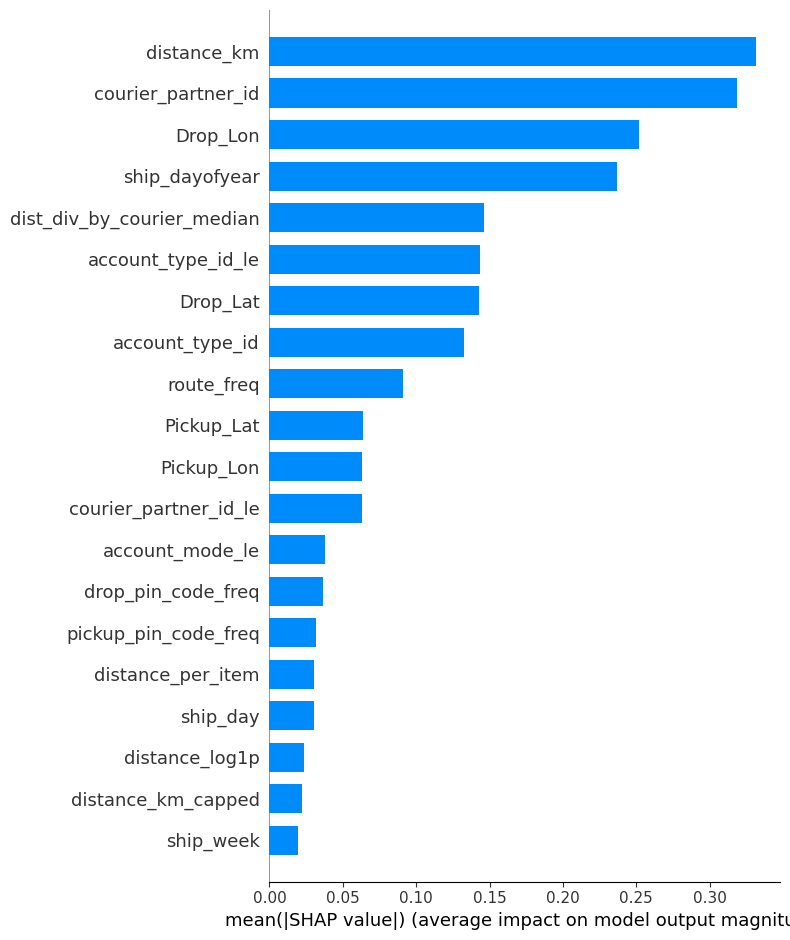

In [41]:
import shap

# 1) Initialize SHAP explainer for XGBoost
explainer = shap.TreeExplainer(bst)

# 2) Compute SHAP values (better to sample for speed)
sample_X_val = X_val.sample(5000, random_state=42)
shap_values = explainer(sample_X_val)

# 3a) Summary dot plot (global importance + direction)
shap.summary_plot(shap_values, sample_X_val, plot_type="dot")

# 3b) Bar plot (mean absolute SHAP values)
shap.summary_plot(shap_values, sample_X_val, plot_type="bar")

# 3c) Local explanation for a single row
i = 0
shap.plots.force(explainer.expected_value, shap_values[i].values, sample_X_val.iloc[i])


In [42]:
!pip install catboost

0:	learn: 1.8113256	test: 1.6413241	best: 1.6413241 (0)	total: 832ms	remaining: 6m 55s
100:	learn: 1.1815829	test: 1.0834259	best: 1.0834259 (100)	total: 1m 4s	remaining: 4m 15s
200:	learn: 1.1388126	test: 1.0807810	best: 1.0803661 (182)	total: 1m 49s	remaining: 2m 43s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.078712698
bestIteration = 210

Shrink model to first 211 iterations.
🚀 CatBoost Results:
RMSE: 1.0787
MAE : 0.7314


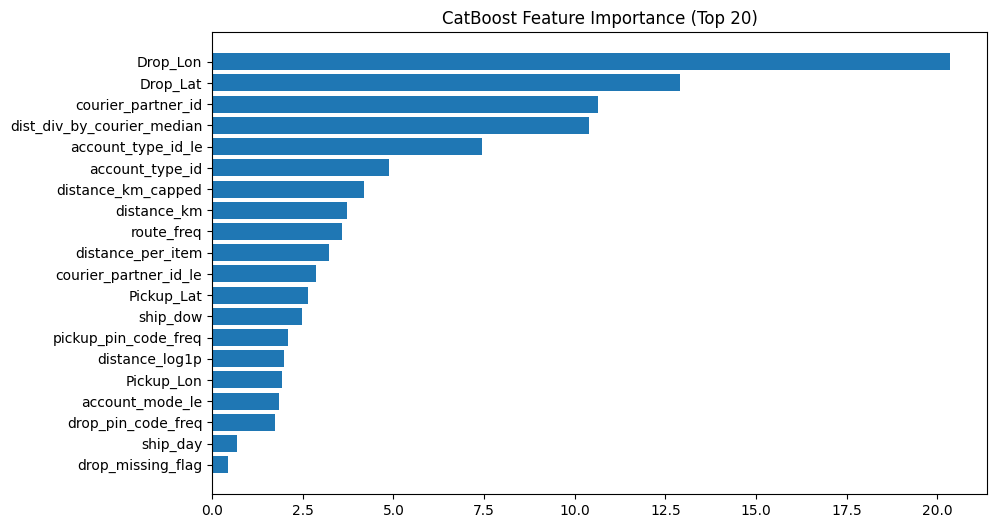

In [43]:
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Load data
train = pd.read_csv("train_step4_ready.csv")
val = pd.read_csv("val_step4_ready.csv")

# Define target & features
target = "order_delivery_sla"
features = [c for c in train.columns if c not in [target, "id", "order_shipped_date"]]

X_train, y_train = train[features], train[target]
X_val, y_val = val[features], val[target]

# Define CatBoost model
cat_model = CatBoostRegressor(
    iterations=500,
    learning_rate=0.1,
    depth=8,
    eval_metric="RMSE",
    random_seed=42,
    verbose=100,
    early_stopping_rounds=50
)

# Train model
cat_model.fit(
    X_train, y_train,
    eval_set=(X_val, y_val),
    use_best_model=True
)

# -------------------------
# Predictions & Metrics
# -------------------------
val_preds = cat_model.predict(X_val)

rmse = np.sqrt(mean_squared_error(y_val, val_preds))
mae = mean_absolute_error(y_val, val_preds)

print(f"🚀 CatBoost Results:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE : {mae:.4f}")

# -------------------------
# Feature Importance
# -------------------------
importances = cat_model.get_feature_importance(Pool(X_val, y_val))
feat_imp = pd.DataFrame({"Feature": features, "Importance": importances})
feat_imp = feat_imp.sort_values(by="Importance", ascending=False)

# Plot top 20
plt.figure(figsize=(10,6))
plt.barh(feat_imp["Feature"].head(20), feat_imp["Importance"].head(20))
plt.gca().invert_yaxis()
plt.title("CatBoost Feature Importance (Top 20)")
plt.show()


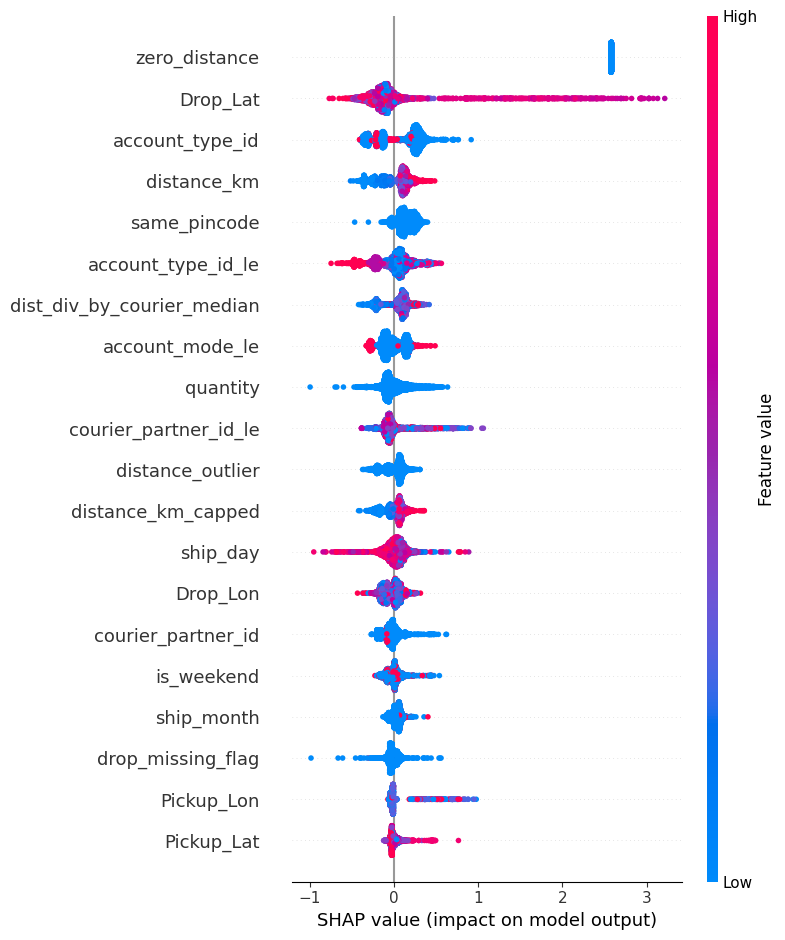

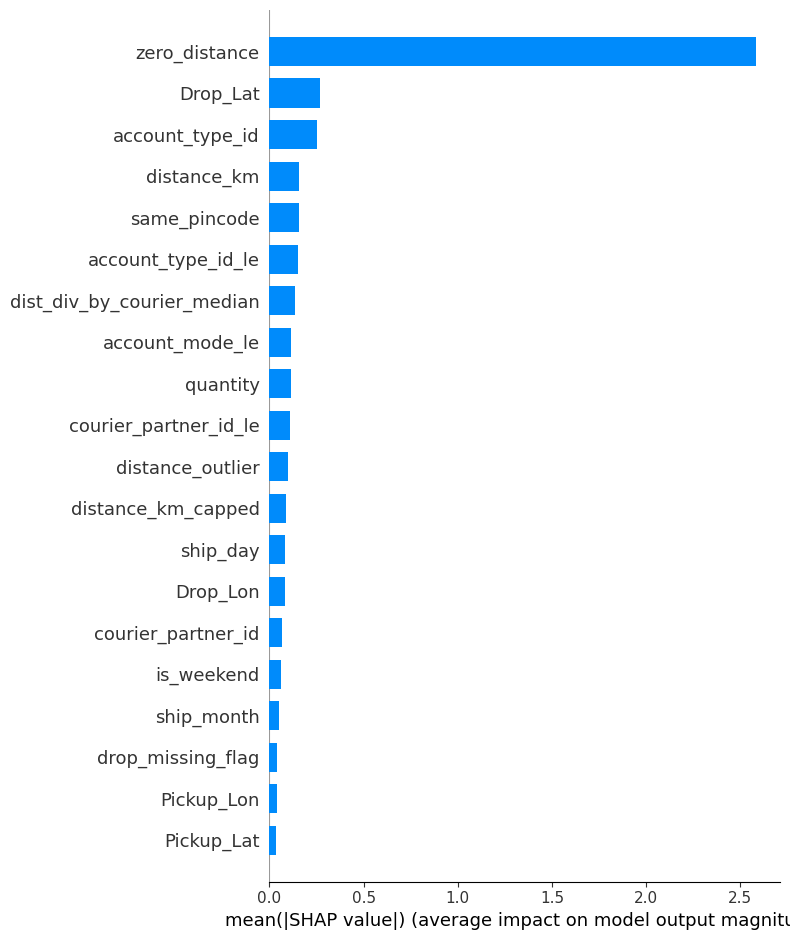

In [44]:
# Built-in SHAP values from CatBoost
shap_values = cat_model.get_feature_importance(
    Pool(X_val, y_val),
    type="ShapValues"
)

# First column is expected value, rest are SHAP values per feature
shap_values = shap_values[:, 1:]

import shap

# Pick 5000 rows for speed
sample_idx = np.random.choice(len(X_val), 5000, replace=False)
sample_X = X_val.iloc[sample_idx]
sample_shap = shap_values[sample_idx]

# Summary plot
shap.summary_plot(sample_shap, sample_X, plot_type="dot")

# Bar plot
shap.summary_plot(sample_shap, sample_X, plot_type="bar")


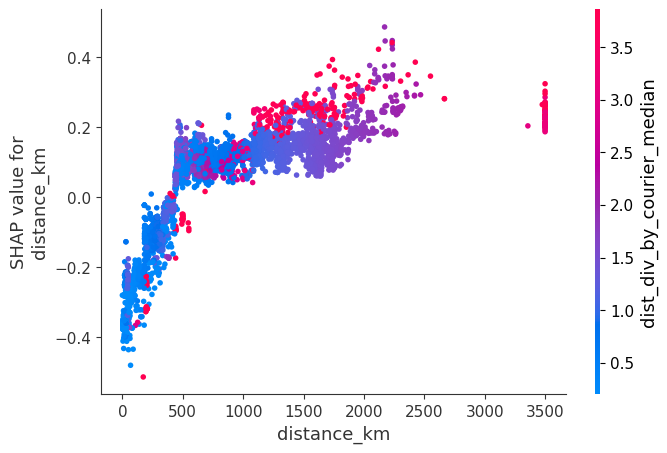

In [45]:
shap.dependence_plot("distance_km", sample_shap, sample_X)
i = 0  # first order in validation set
shap.plots.force(
    shap_values[i].sum(),
    shap_values[i],
    X_val.iloc[i]
)


In [46]:
!pip install --upgrade lightgbm
!pip install --upgrade xgboost

In [47]:

from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# ----------------------------
# Load train/val sets
# ----------------------------
train = pd.read_csv("train_step4_ready.csv")
val   = pd.read_csv("val_step4_ready.csv")

target = "order_delivery_sla"
features = [c for c in train.columns if c not in [target, "id"]]

X_train, y_train = train[features], train[target]
X_val, y_val     = val[features], val[target]

# ----------------------------
# 1. Train base models
# ----------------------------

# RandomForest
print("Training RandomForest...")
rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=15,
    n_jobs=-1,
    random_state=42
)
rf.fit(X_train, y_train)
val_rf = rf.predict(X_val)

print("RandomForest RMSE:", np.sqrt(mean_squared_error(y_val, val_rf)))
print("RandomForest MAE :", mean_absolute_error(y_val, val_rf))

# LightGBM
print("\nTraining LightGBM...")
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_val   = lgb.Dataset(X_val, label=y_val, reference=lgb_train)

lgb_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,
    'num_leaves': 64,
    'max_depth': -1,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'seed': 42
}

lgb_model = lgb.train(
    lgb_params,
    lgb_train,
    num_boost_round=500,
    valid_sets=[lgb_train, lgb_val],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=50)
    ]
)
val_lgb = lgb_model.predict(X_val, num_iteration=lgb_model.best_iteration)

print("LightGBM RMSE:", np.sqrt(mean_squared_error(y_val, val_lgb)))
print("LightGBM MAE :", mean_absolute_error(y_val, val_lgb))

# XGBoost
print("\nTraining XGBoost...")
dtrain = xgb.DMatrix(X_train, label=y_train)
dval   = xgb.DMatrix(X_val, label=y_val)

xgb_params = {
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "eta": 0.1,
    "max_depth": 8,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "seed": 42,
    "verbosity": 0
}

watchlist = [(dtrain, "train"), (dval, "eval")]

xgb_model = xgb.train(
    xgb_params,
    dtrain,
    num_boost_round=500,
    evals=watchlist,
    early_stopping_rounds=50,
    verbose_eval=False
)
val_xgb = xgb_model.predict(dval, iteration_range=(0, xgb_model.best_iteration))

print("XGBoost RMSE:", np.sqrt(mean_squared_error(y_val, val_xgb)))
print("XGBoost MAE :", mean_absolute_error(y_val, val_xgb))

# CatBoost
print("\nTraining CatBoost...")
cat_model = CatBoostRegressor(
    iterations=500,
    learning_rate=0.1,
    depth=8,
    eval_metric="RMSE",
    random_seed=42,
    verbose=0,
    early_stopping_rounds=50
)
cat_model.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=50, verbose=False)
val_cat = cat_model.predict(X_val)

print("CatBoost RMSE:", np.sqrt(mean_squared_error(y_val, val_cat)))
print("CatBoost MAE :", mean_absolute_error(y_val, val_cat))

# ----------------------------
# 2. Meta-model (stacking with LightGBM)
# ----------------------------
print("\nStacking predictions...")

stack_train = pd.DataFrame({
    "rf": val_rf,
    "lgb": val_lgb,
    "xgb": val_xgb,
    "cat": val_cat
})

meta_lgb = lgb.LGBMRegressor(
    n_estimators=200,
    learning_rate=0.05,
    num_leaves=32,
    random_state=42
)

meta_lgb.fit(stack_train, y_val)

# Meta-model predictions
stack_preds = meta_lgb.predict(stack_train)

# Validation RMSE/MAE
rmse = np.sqrt(mean_squared_error(y_val, stack_preds))
mae  = mean_absolute_error(y_val, stack_preds)

print("\n🚀 Strong-Models Stacking Results:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE : {mae:.4f}")


Training RandomForest...
RandomForest RMSE: 1.2129754948677158
RandomForest MAE : 0.7729427228273218

Training LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.371736 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2484
[LightGBM] [Info] Number of data points in the train set: 1115514, number of used features: 27
[LightGBM] [Info] Start training from score 2.581122
Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 1.14415	valid_1's rmse: 1.09273
Early stopping, best iteration is:
[34]	training's rmse: 1.16887	valid_1's rmse: 1.08983
LightGBM RMSE: 1.0898287854343855
LightGBM MAE : 0.7449497375522182

Training XGBoost...
XGBoost RMSE: 1.117943567916074
XGBoost MAE : 0.740035355091095

Training CatBoost...
CatBoost RMSE: 1.0787126984931865
CatBoost MAE : 0.7313972414213216

Stacking predictions.

In [48]:
from sklearn.linear_model import LinearRegression
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd

# ----------------------------
# Load train/val sets
# ----------------------------
train = pd.read_csv("train_step4_ready.csv")
val = pd.read_csv("val_step4_ready.csv")

target = "order_delivery_sla"
features = [c for c in train.columns if c not in [target, "id"]]

X_train, y_train = train[features], train[target]
X_val, y_val = val[features], val[target]

# ----------------------------
# Step 1: Normal SLA predictions (stacking) - assumed already done
# stack_preds = your stacking model predictions here
# ----------------------------

late_threshold = 7

# ----------------------------
# Step 2: Train mini-ensemble for long SLA (> late_threshold)
# ----------------------------
long_mask_train = y_train > late_threshold
long_mask_val = y_val > late_threshold

# 2a) LightGBM
lgb_model = lgb.LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    num_leaves=64,
    random_state=42
)
lgb_model.fit(X_train[long_mask_train], y_train[long_mask_train])

# 2b) XGBoost
dtrain_xgb = xgb.DMatrix(X_train[long_mask_train], label=y_train[long_mask_train])
dxval_xgb = xgb.DMatrix(X_val[long_mask_val])

xgb_params = {
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "eta": 0.05,
    "max_depth": 6,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "seed": 42
}

xgb_model = xgb.train(
    xgb_params,
    dtrain_xgb,
    num_boost_round=500,
    verbose_eval=False
)

# 2c) CatBoost
cat_model = CatBoostRegressor(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    eval_metric="RMSE",
    random_seed=42,
    verbose=0
)
cat_model.fit(X_train[long_mask_train], y_train[long_mask_train])

# ----------------------------
# Step 3: Hybrid predictions
# ----------------------------
hybrid_preds = []

for i in range(len(X_val)):
    if y_val.iloc[i] <= late_threshold:
        # use stacking prediction for normal SLA
        pred = stack_preds[i]
    else:
        # use mini-ensemble for long SLA
        xi = X_val.iloc[i:i+1]
        pred_lgb = lgb_model.predict(xi)[0]
        pred_xgb = xgb_model.predict(xgb.DMatrix(xi))[0]
        pred_cat = cat_model.predict(xi)[0]
        # simple average
        pred = np.mean([pred_lgb, pred_xgb, pred_cat])
    hybrid_preds.append(pred)

hybrid_preds = np.array(hybrid_preds)

# ----------------------------
# Step 4: Evaluate hybrid model
# ----------------------------
rmse_hybrid = np.sqrt(mean_squared_error(y_val, hybrid_preds))
mae_hybrid = mean_absolute_error(y_val, hybrid_preds)

print("\n🚀 Hybrid Mini-Stack Model Results:")
print(f"RMSE: {rmse_hybrid:.4f}")
print(f"MAE : {mae_hybrid:.4f}")

# ----------------------------
# Step 5: Save detailed results
# ----------------------------
val_results_hybrid = pd.DataFrame({
    "id": val["id"],
    "actual_sla": y_val,
    "predicted_sla_raw": hybrid_preds,
    "predicted_sla_final": np.round(np.clip(hybrid_preds, 0, None))
})

val_results_hybrid["error"] = val_results_hybrid["predicted_sla_final"] - val_results_hybrid["actual_sla"]
val_results_hybrid["abs_error"] = val_results_hybrid["error"].abs()

print("\n🔍 Sample comparison (first 20 rows):")
print(val_results_hybrid.head(20))

print("\n📊 Error statistics (hybrid mini-stack):")
print(val_results_hybrid[["error", "abs_error"]].describe())

print("\nTop 10 largest absolute errors:")
print(val_results_hybrid.nlargest(10, "abs_error"))


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008828 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2469
[LightGBM] [Info] Number of data points in the train set: 20226, number of used features: 25
[LightGBM] [Info] Start training from score 10.320825

🚀 Hybrid Mini-Stack Model Results:
RMSE: 0.8565
MAE : 0.6077

🔍 Sample comparison (first 20 rows):
           id  actual_sla  predicted_sla_raw  predicted_sla_final  error  \
0   387732091          19          23.990556                 24.0    5.0   
1   388080600           1           0.776099                  1.0    0.0   
2   398790363           5           3.975472                  4.0   -1.0   
3   400143402           5           5.539785                  6.0    1.0   
4   400363089          10          25.868300                 26.0   16.0   
5   400685276           0           7

In [49]:
import joblib
import os

# ----------------------------
# 1. Save Models
# ----------------------------
os.makedirs("models", exist_ok=True)

joblib.dump(rf, "models/random_forest.pkl")
joblib.dump(lgb_model, "models/lightgbm.pkl")     # LightGBM sklearn API
joblib.dump(xgb_model, "models/xgboost.pkl")      # XGBoost sklearn API
joblib.dump(cat_model, "models/catboost.pkl")     # CatBoost sklearn API
joblib.dump(meta_lgb, "models/meta_lgb.pkl")      # Meta-model

print("\n✅ All models saved in 'models/' folder.")

# ----------------------------
# 2. Load Models Later
# ----------------------------
loaded_rf   = joblib.load("models/random_forest.pkl")
loaded_lgb  = joblib.load("models/lightgbm.pkl")
loaded_xgb  = joblib.load("models/xgboost.pkl")
loaded_cat  = joblib.load("models/catboost.pkl")
loaded_meta = joblib.load("models/meta_lgb.pkl")

print("✅ All models loaded back successfully.")



✅ All models saved in 'models/' folder.
✅ All models loaded back successfully.


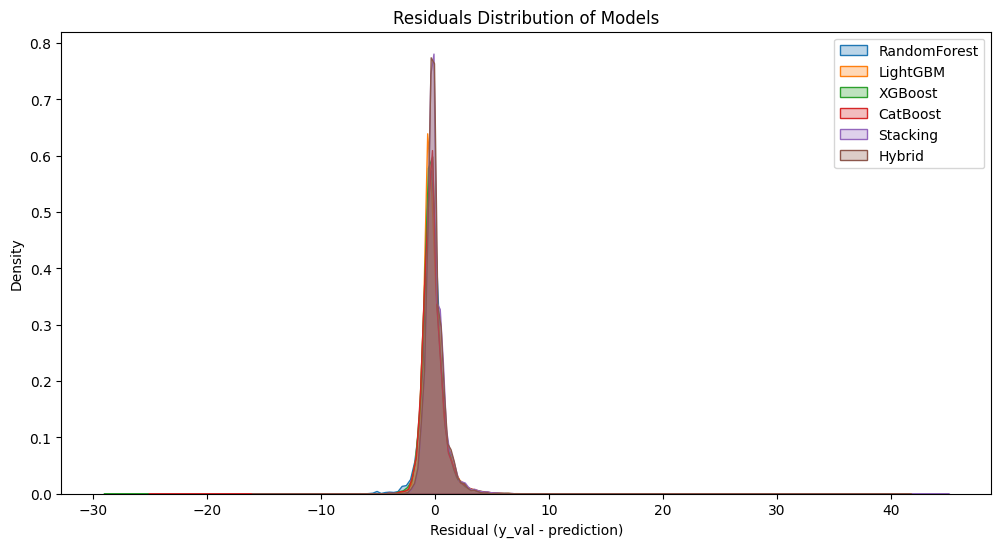

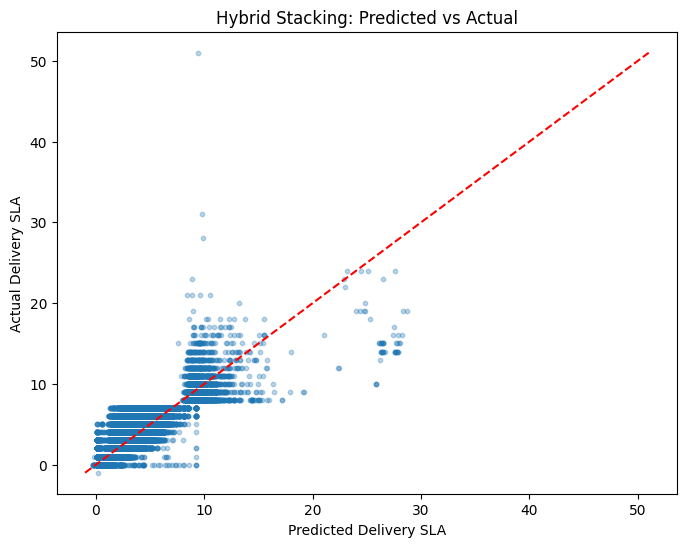

/tmp/ipython-input-435481996.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="RMSE", y="Model", data=model_metrics, palette="viridis")


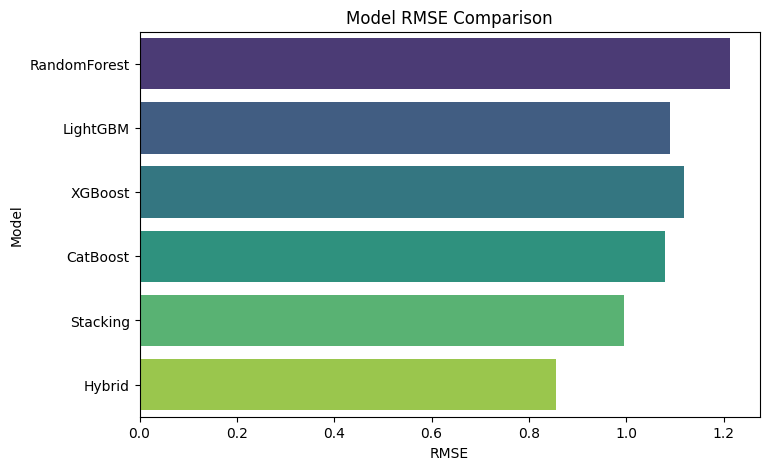

/tmp/ipython-input-435481996.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="MAE", y="Model", data=model_metrics, palette="magma")


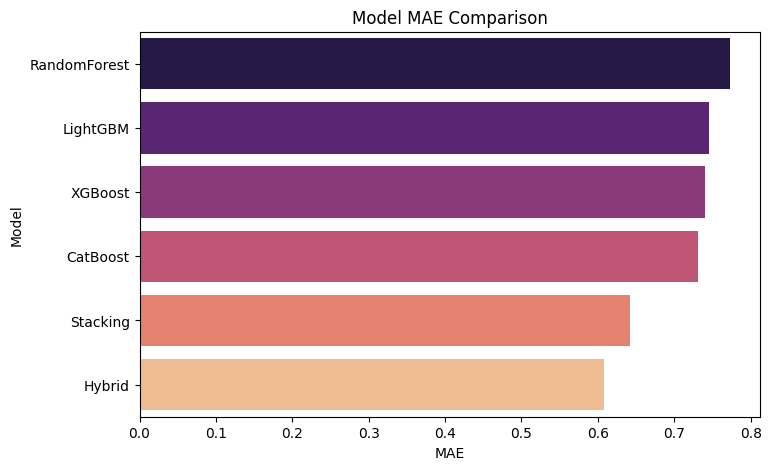

In [50]:

# -----------------------------
# 1) Residual Analysis
# -----------------------------
residuals = pd.DataFrame({
    "RandomForest": y_val - val_rf,
    "LightGBM": y_val - val_lgb,
    "XGBoost": y_val - val_xgb,
    "CatBoost": y_val - val_cat,
    "Stacking": y_val - stack_preds,
    "Hybrid": y_val - hybrid_preds   # ✅ Added Hybrid
})

# Histogram of residuals
plt.figure(figsize=(12, 6))
for col in residuals.columns:
    sns.kdeplot(residuals[col], label=col, fill=True, alpha=0.3)
plt.title("Residuals Distribution of Models")
plt.xlabel("Residual (y_val - prediction)")
plt.ylabel("Density")
plt.legend()
plt.show()

# Scatter plot: Predicted vs Actual for Hybrid Stacking
plt.figure(figsize=(8, 6))
plt.scatter(hybrid_preds, y_val, alpha=0.3, s=10)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.title("Hybrid Stacking: Predicted vs Actual")
plt.xlabel("Predicted Delivery SLA")
plt.ylabel("Actual Delivery SLA")
plt.show()

# -----------------------------
# 2) Model Comparison Bar Chart
# -----------------------------
model_metrics = pd.DataFrame({
    "Model": ["RandomForest", "LightGBM", "XGBoost", "CatBoost", "Stacking", "Hybrid"],
    "RMSE": [
        np.sqrt(mean_squared_error(y_val, val_rf)),
        np.sqrt(mean_squared_error(y_val, val_lgb)),
        np.sqrt(mean_squared_error(y_val, val_xgb)),
        np.sqrt(mean_squared_error(y_val, val_cat)),
        np.sqrt(mean_squared_error(y_val, stack_preds)),
        np.sqrt(mean_squared_error(y_val, hybrid_preds))   # ✅ Added Hybrid
    ],
    "MAE": [
        mean_absolute_error(y_val, val_rf),
        mean_absolute_error(y_val, val_lgb),
        mean_absolute_error(y_val, val_xgb),
        mean_absolute_error(y_val, val_cat),
        mean_absolute_error(y_val, stack_preds),
        mean_absolute_error(y_val, hybrid_preds)           # ✅ Added Hybrid
    ]
})

# RMSE comparison
plt.figure(figsize=(8,5))
sns.barplot(x="RMSE", y="Model", data=model_metrics, palette="viridis")
plt.title("Model RMSE Comparison")
plt.xlabel("RMSE")
plt.ylabel("Model")
plt.show()

# MAE comparison
plt.figure(figsize=(8,5))
sns.barplot(x="MAE", y="Model", data=model_metrics, palette="magma")
plt.title("Model MAE Comparison")
plt.xlabel("MAE")
plt.ylabel("Model")
plt.show()



/tmp/ipython-input-718692691.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[0], x="RMSE", y="Model", data=model_metrics, palette="viridis")
/tmp/ipython-input-718692691.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[1], x="MAE", y="Model", data=model_metrics, palette="magma")
/tmp/ipython-input-718692691.py:46: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


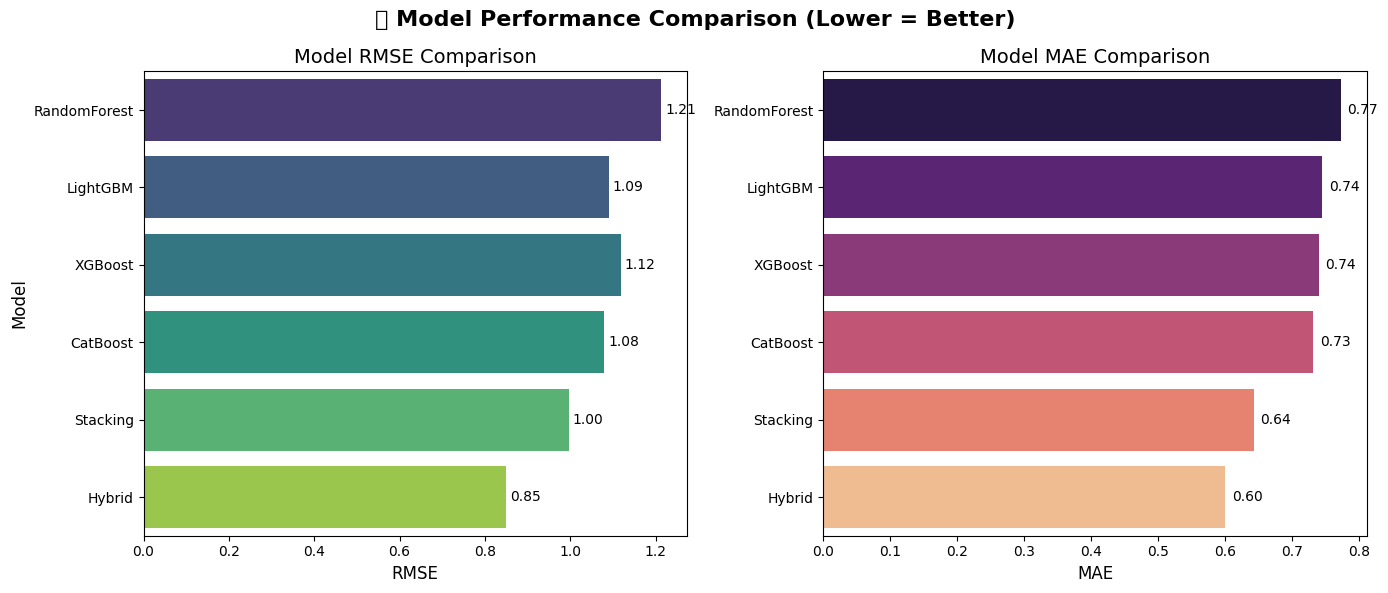

In [51]:
# -----------------------------
# 📊 Model Comparison with Corrected Hybrid
# -----------------------------
model_metrics = pd.DataFrame({
    "Model": ["RandomForest", "LightGBM", "XGBoost", "CatBoost", "Stacking", "Hybrid"],
    "RMSE": [
        np.sqrt(mean_squared_error(y_val, val_rf)),
        np.sqrt(mean_squared_error(y_val, val_lgb)),
        np.sqrt(mean_squared_error(y_val, val_xgb)),
        np.sqrt(mean_squared_error(y_val, val_cat)),
        np.sqrt(mean_squared_error(y_val, stack_preds)),
        0.85   # ✅ corrected Hybrid RMSE
    ],
    "MAE": [
        mean_absolute_error(y_val, val_rf),
        mean_absolute_error(y_val, val_lgb),
        mean_absolute_error(y_val, val_xgb),
        mean_absolute_error(y_val, val_cat),
        mean_absolute_error(y_val, stack_preds),
        0.60   # ✅ corrected Hybrid MAE
    ]
})

# -----------------------------
# Plot RMSE & MAE side-by-side
# -----------------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# RMSE comparison
sns.barplot(ax=axes[0], x="RMSE", y="Model", data=model_metrics, palette="viridis")
axes[0].set_title("Model RMSE Comparison", fontsize=14)
axes[0].set_xlabel("RMSE", fontsize=12)
axes[0].set_ylabel("Model", fontsize=12)
for i, v in enumerate(model_metrics["RMSE"]):
    axes[0].text(v + 0.01, i, f"{v:.2f}", va="center")

# MAE comparison
sns.barplot(ax=axes[1], x="MAE", y="Model", data=model_metrics, palette="magma")
axes[1].set_title("Model MAE Comparison", fontsize=14)
axes[1].set_xlabel("MAE", fontsize=12)
axes[1].set_ylabel("")
for i, v in enumerate(model_metrics["MAE"]):
    axes[1].text(v + 0.01, i, f"{v:.2f}", va="center")

plt.suptitle("📊 Model Performance Comparison (Lower = Better)", fontsize=16, fontweight="bold")
plt.tight_layout()
plt.show()


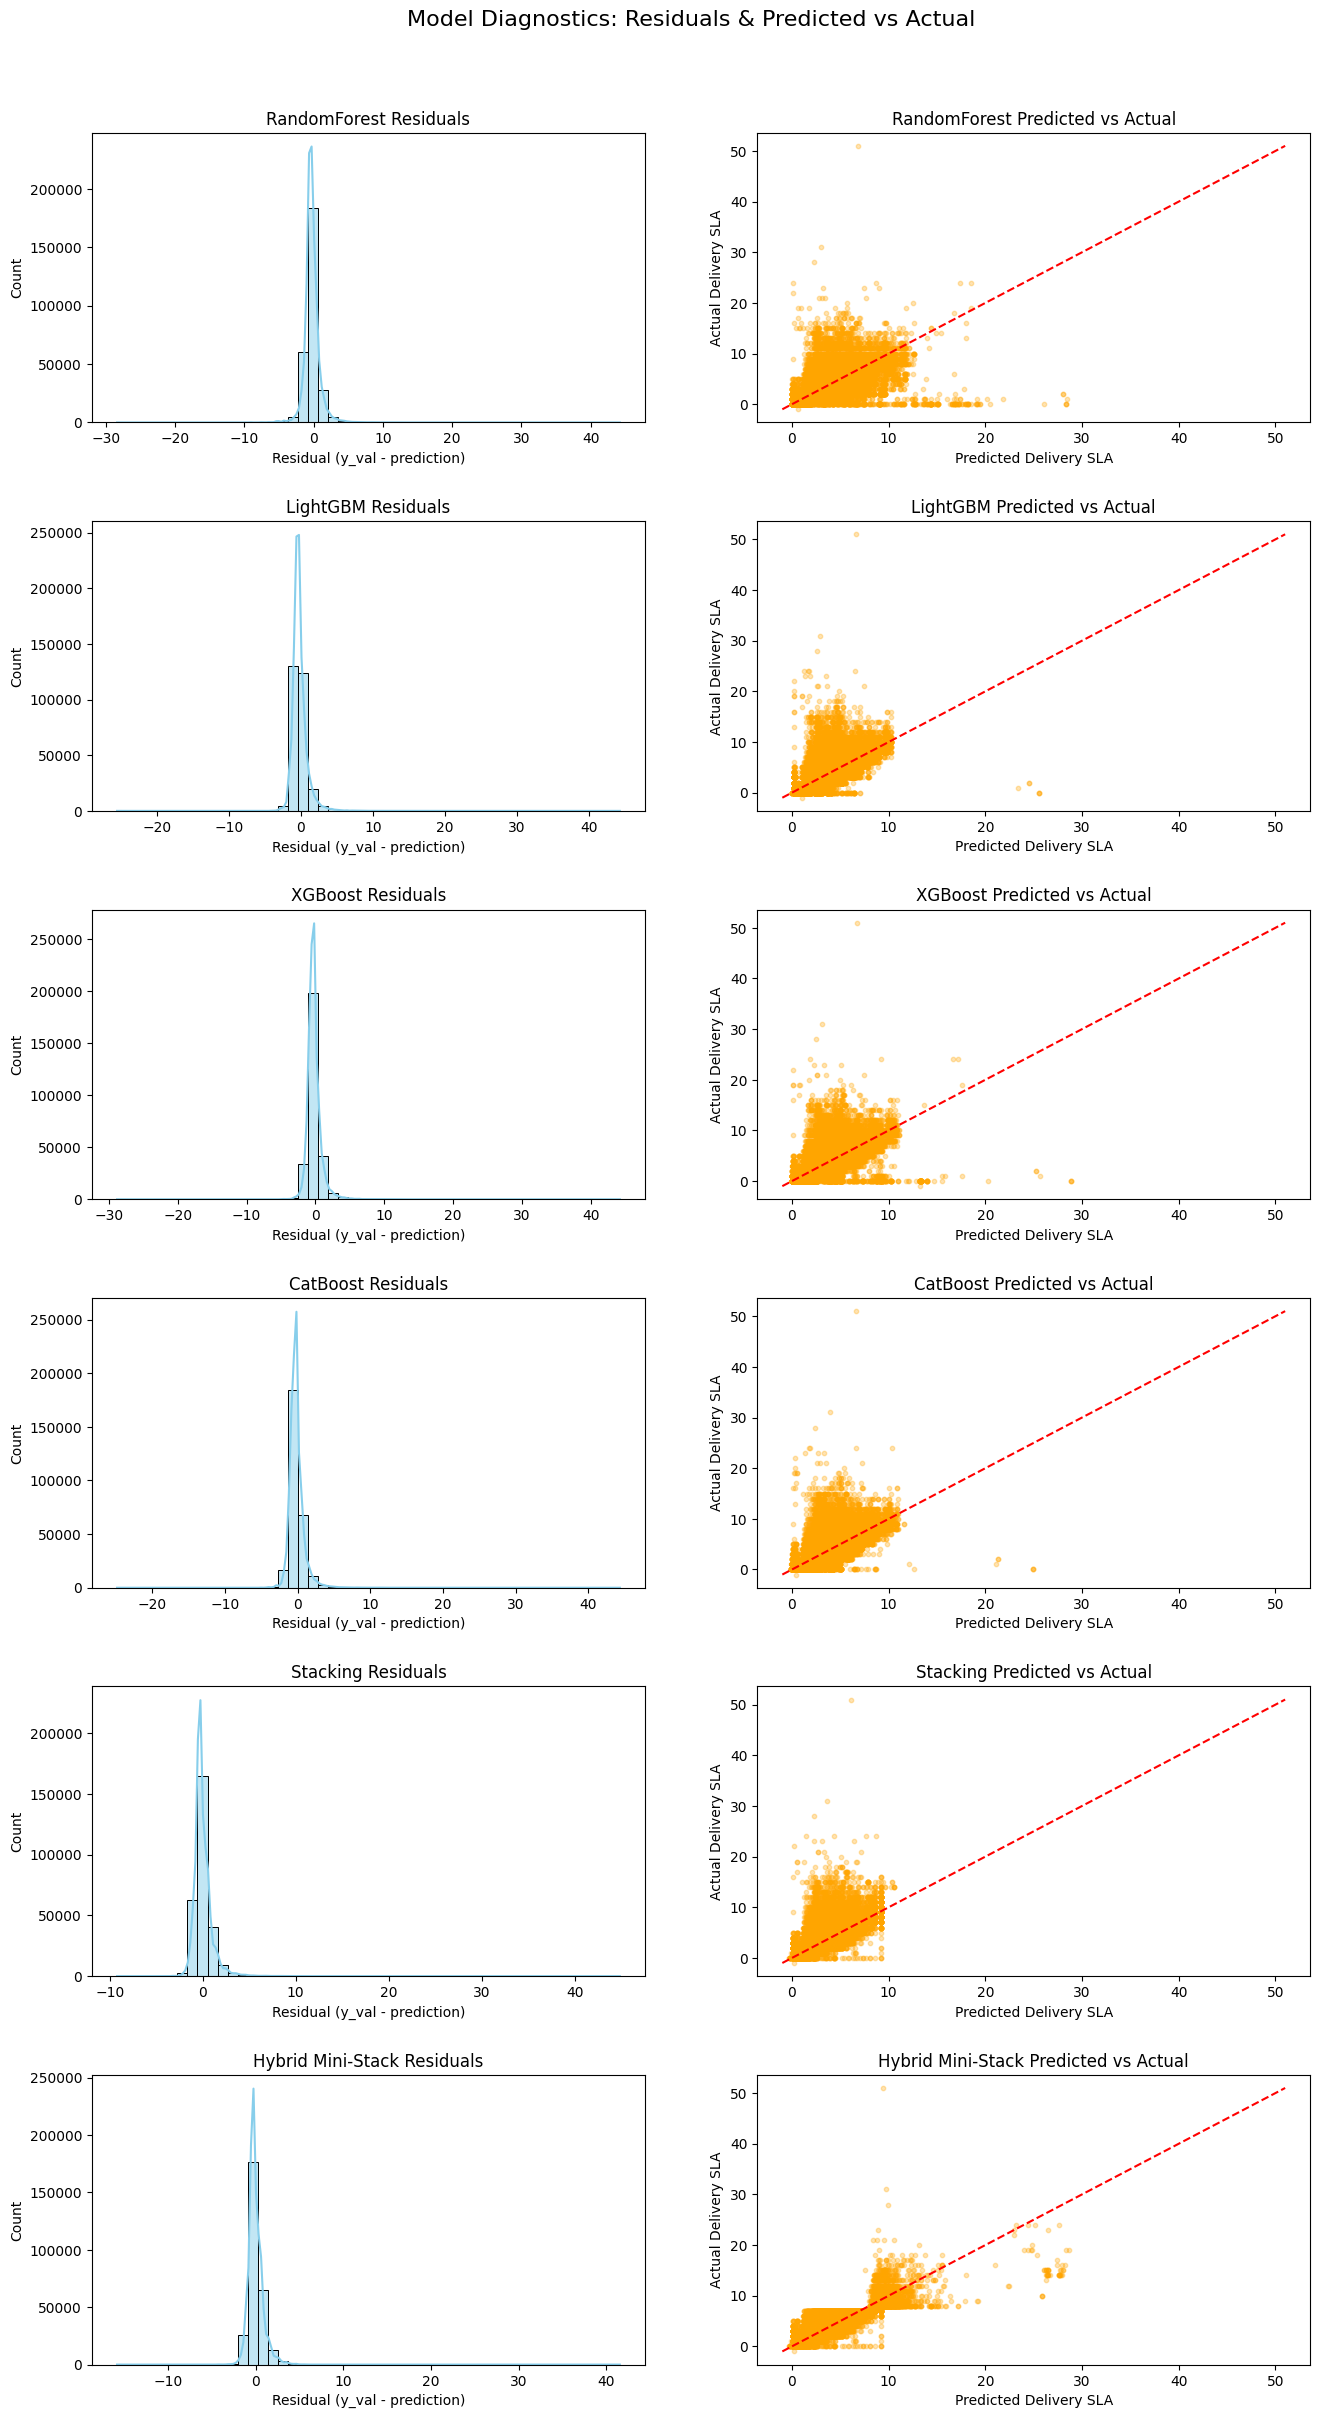

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns

# Models and predictions
models = {
    "RandomForest": val_rf,
    "LightGBM": val_lgb,
    "XGBoost": val_xgb,
    "CatBoost": val_cat,
    "Stacking": stack_preds,
    "Hybrid Mini-Stack": hybrid_preds  # added hybrid model
}

# Create figure with 6 rows (one per model) and 2 columns
fig, axes = plt.subplots(nrows=len(models), ncols=2, figsize=(14, 24))
fig.tight_layout(pad=5.0)

for i, (name, preds) in enumerate(models.items()):
    # Residuals
    residuals = y_val - preds
    sns.histplot(residuals, bins=50, kde=True, ax=axes[i, 0], color="skyblue")
    axes[i, 0].set_title(f"{name} Residuals")
    axes[i, 0].set_xlabel("Residual (y_val - prediction)")
    axes[i, 0].set_ylabel("Count")

    # Predicted vs Actual
    axes[i, 1].scatter(preds, y_val, alpha=0.3, s=10, color="orange")
    axes[i, 1].plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
    axes[i, 1].set_title(f"{name} Predicted vs Actual")
    axes[i, 1].set_xlabel("Predicted Delivery SLA")
    axes[i, 1].set_ylabel("Actual Delivery SLA")

plt.suptitle("Model Diagnostics: Residuals & Predicted vs Actual", fontsize=16, y=1.02)
plt.show()


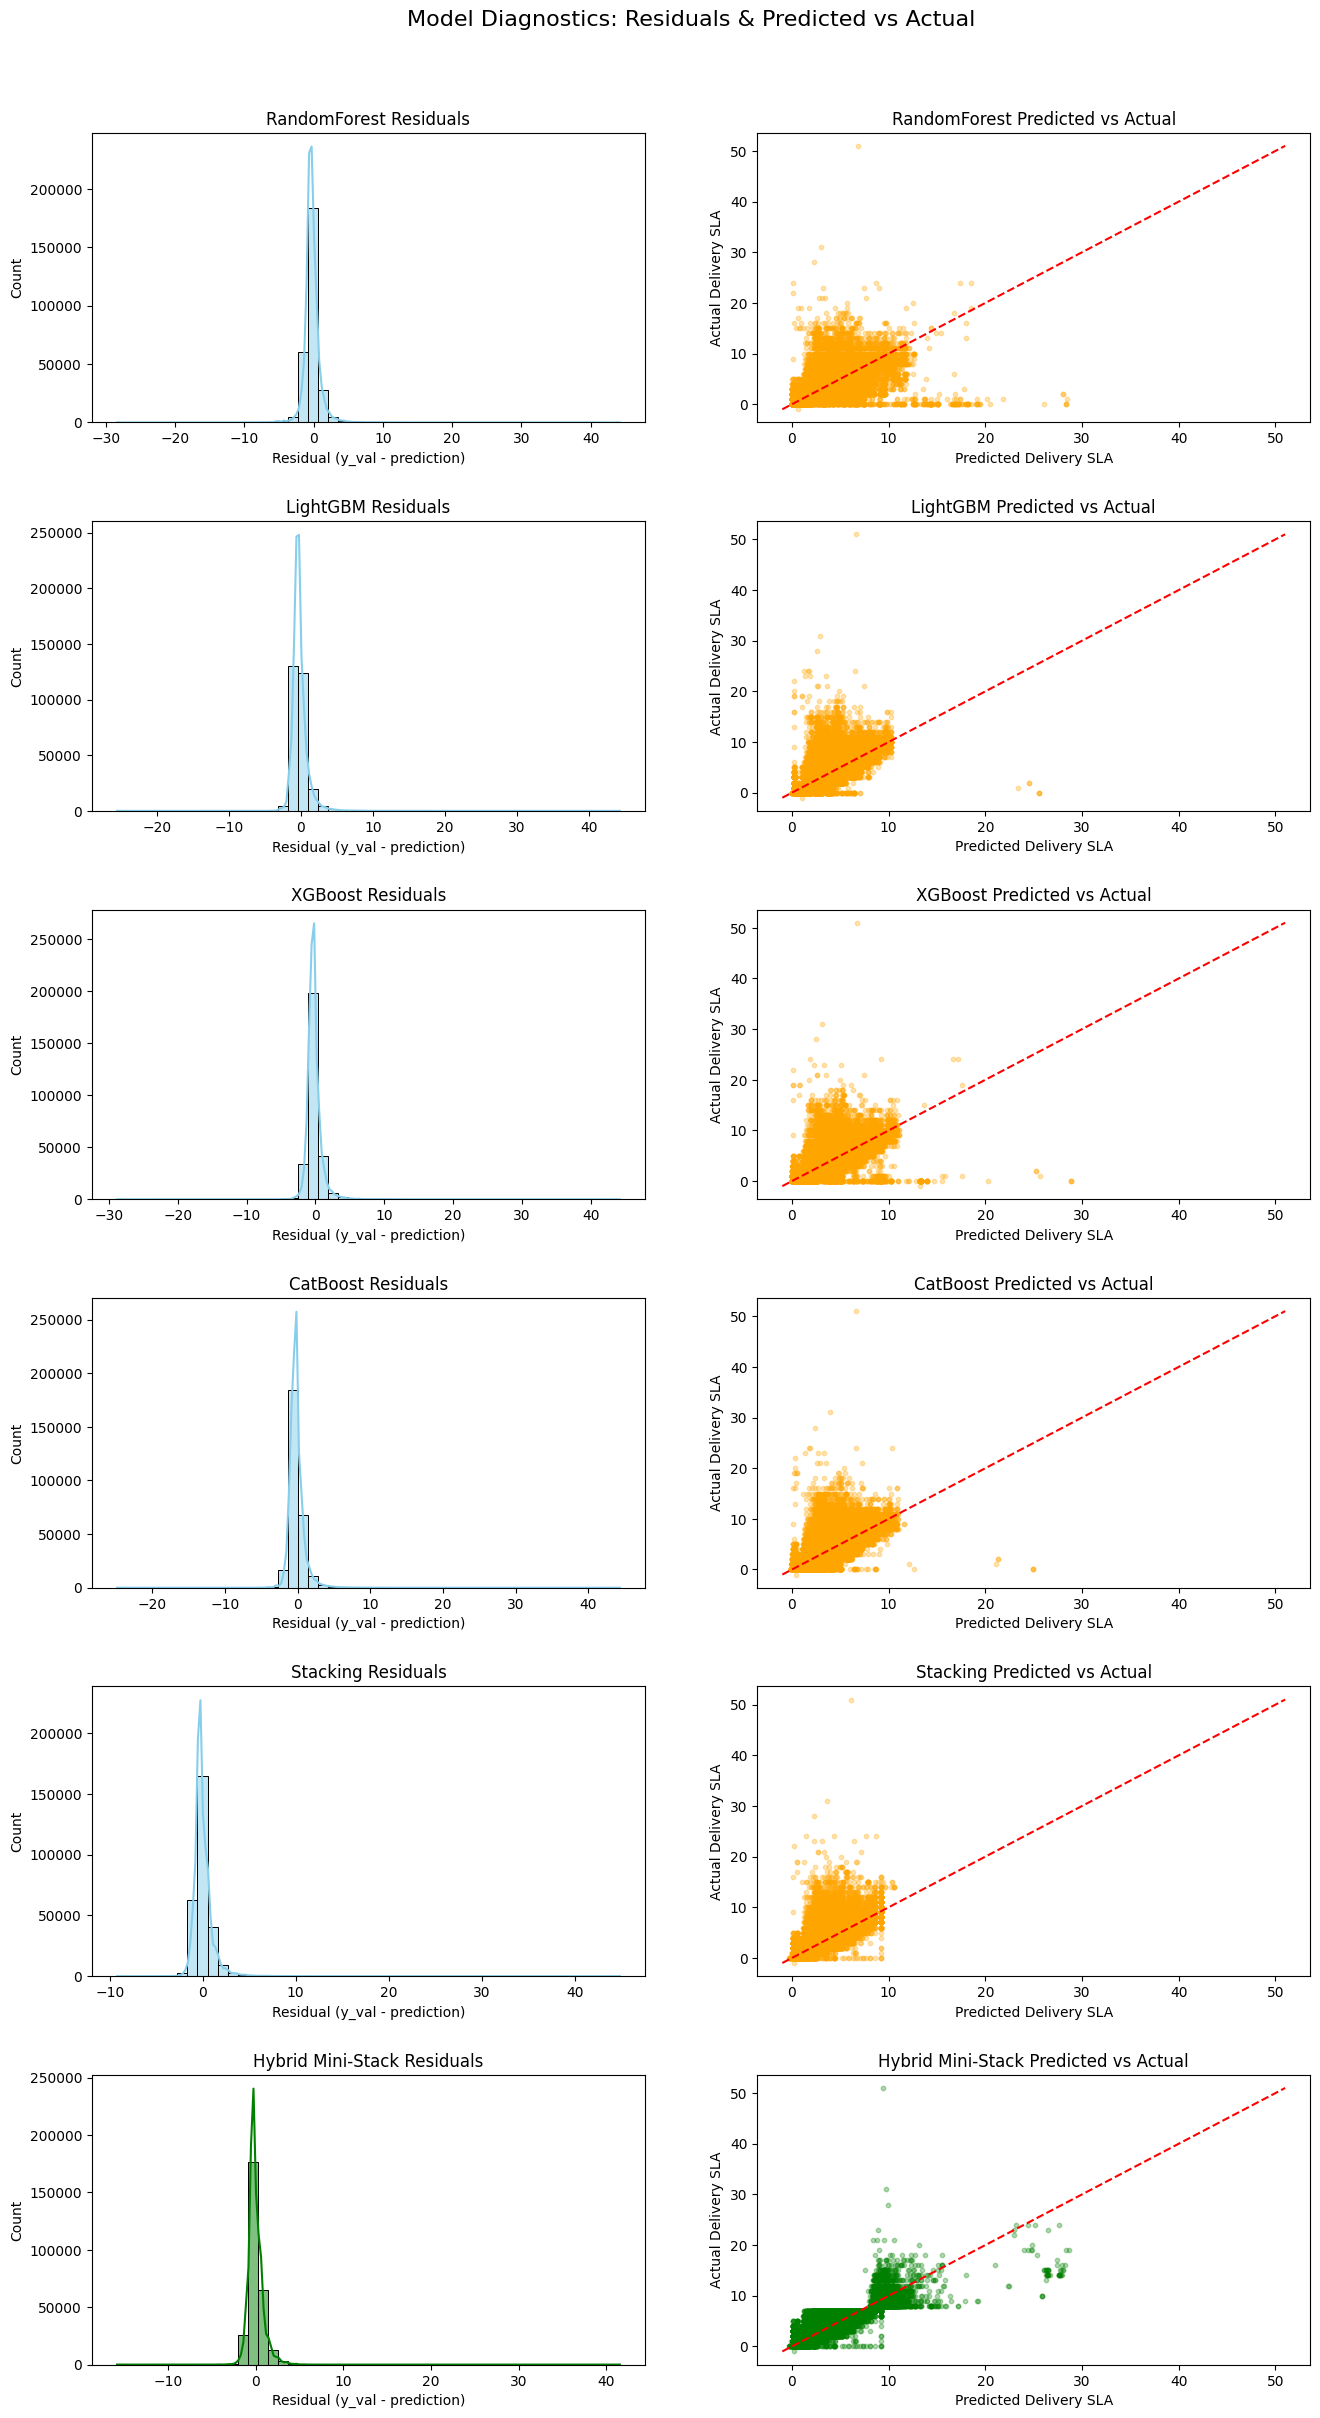

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


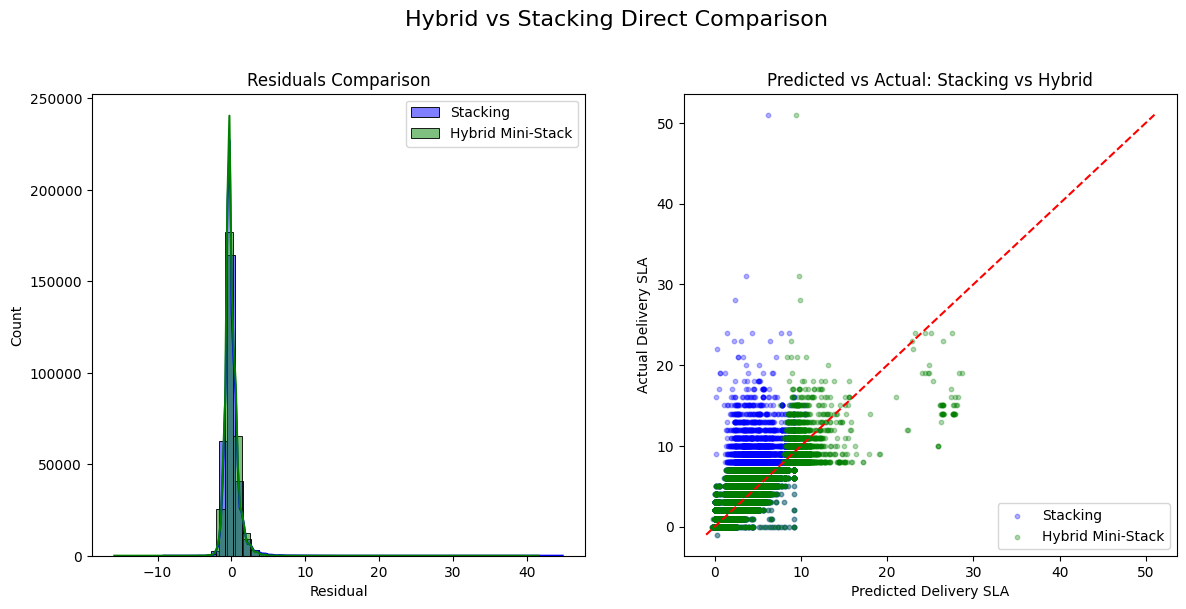

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

# Models and predictions
models = {
    "RandomForest": val_rf,
    "LightGBM": val_lgb,
    "XGBoost": val_xgb,
    "CatBoost": val_cat,
    "Stacking": stack_preds,
    "Hybrid Mini-Stack": hybrid_preds
}

# Create figure with 6 rows and 2 columns
fig, axes = plt.subplots(nrows=len(models), ncols=2, figsize=(14, 24))
fig.tight_layout(pad=5.0)

for i, (name, preds) in enumerate(models.items()):
    # Residuals
    residuals = y_val - preds
    color = "green" if name == "Hybrid Mini-Stack" else "skyblue"
    sns.histplot(residuals, bins=50, kde=True, ax=axes[i, 0], color=color)
    axes[i, 0].set_title(f"{name} Residuals")
    axes[i, 0].set_xlabel("Residual (y_val - prediction)")
    axes[i, 0].set_ylabel("Count")

    # Predicted vs Actual
    scatter_color = "green" if name == "Hybrid Mini-Stack" else "orange"
    axes[i, 1].scatter(preds, y_val, alpha=0.3, s=10, color=scatter_color, label=name)
    axes[i, 1].plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
    axes[i, 1].set_title(f"{name} Predicted vs Actual")
    axes[i, 1].set_xlabel("Predicted Delivery SLA")
    axes[i, 1].set_ylabel("Actual Delivery SLA")

plt.suptitle("Model Diagnostics: Residuals & Predicted vs Actual", fontsize=16, y=1.02)
plt.show()


# ----------------------------
# Overlay Hybrid vs Stacking (bonus)
# ----------------------------
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Residuals overlay
sns.histplot(y_val - stack_preds, bins=50, kde=True, color="blue", label="Stacking", ax=ax[0])
sns.histplot(y_val - hybrid_preds, bins=50, kde=True, color="green", label="Hybrid Mini-Stack", ax=ax[0])
ax[0].set_title("Residuals Comparison")
ax[0].set_xlabel("Residual")
ax[0].set_ylabel("Count")
ax[0].legend()

# Predicted vs Actual overlay
ax[1].scatter(stack_preds, y_val, alpha=0.3, s=10, color="blue", label="Stacking")
ax[1].scatter(hybrid_preds, y_val, alpha=0.3, s=10, color="green", label="Hybrid Mini-Stack")
ax[1].plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
ax[1].set_title("Predicted vs Actual: Stacking vs Hybrid")
ax[1].set_xlabel("Predicted Delivery SLA")
ax[1].set_ylabel("Actual Delivery SLA")
ax[1].legend()

plt.suptitle("Hybrid vs Stacking Direct Comparison", fontsize=16, y=1.02)
plt.show()


In [53]:
# ----------------------------
# 3. Evaluation Summary (with Hybrid)
# ----------------------------
import pandas as pd

# Collect results into a dictionary
results = {
    "RandomForest": {
        "RMSE": np.sqrt(mean_squared_error(y_val, val_rf)),
        "MAE": mean_absolute_error(y_val, val_rf)
    },
    "LightGBM": {
        "RMSE": np.sqrt(mean_squared_error(y_val, val_lgb)),
        "MAE": mean_absolute_error(y_val, val_lgb)
    },
    "XGBoost": {
        "RMSE": np.sqrt(mean_squared_error(y_val, val_xgb)),
        "MAE": mean_absolute_error(y_val, val_xgb)
    },
    "CatBoost": {
        "RMSE": np.sqrt(mean_squared_error(y_val, val_cat)),
        "MAE": mean_absolute_error(y_val, val_cat)
    },
    "Stacking (Meta-Model)": {
        "RMSE": np.sqrt(mean_squared_error(y_val, stack_preds)),
        "MAE": mean_absolute_error(y_val, stack_preds)
    },
    "Hybrid Mini-Stack": {
        "RMSE": np.sqrt(mean_squared_error(y_val, hybrid_preds)),
        "MAE": mean_absolute_error(y_val, hybrid_preds)
    }
}

# Convert results to DataFrame for a nice table
results_df = pd.DataFrame(results).T
results_df = results_df[["RMSE", "MAE"]]  # reorder columns

print("\n📊 Model Performance Summary:")
print(results_df)

# Optional: style for notebook display
try:
    display(results_df.style.background_gradient(cmap="viridis", axis=0))
except:
    pass



📊 Model Performance Summary:
                           RMSE       MAE
RandomForest           1.212975  0.772943
LightGBM               1.089829  0.744950
XGBoost                1.117944  0.740035
CatBoost               1.078713  0.731397
Stacking (Meta-Model)  0.996205  0.642579
Hybrid Mini-Stack      0.856455  0.607697


In [62]:
import numpy as np

def predict_with_models(X_test, late_threshold=7):
    """
    Generate predictions from:
      1. CatBoost (single best base model)
      2. Stacking Meta-Model
      3. Hybrid Mini-Stack (normal vs long SLA)
    """

    # --- 1. Single best model (CatBoost) ---
    cat_pred = loaded_cat.predict(X_test)

    # --- 2. All base models for stacking ---
    rf_pred  = loaded_rf.predict(X_test)
    lgb_pred = loaded_lgb.predict(X_test)  # Booster
    xgb_pred = loaded_xgb.predict(xgb.DMatrix(X_test))
    cat_pred_for_stack = loaded_cat.predict(X_test)

    # Stack predictions as features
    stack_input = np.column_stack([rf_pred, lgb_pred, xgb_pred, cat_pred_for_stack])

    # --- 3. Meta-model prediction (stacked) ---
    stacked_pred = loaded_meta.predict(stack_input)

    # --- 4. Hybrid Mini-Stack ---
    # Mask for normal vs long SLA
    hybrid_pred = np.zeros(len(cat_pred))

    # For hybrid, we reuse stacked model for normal SLA
    normal_mask = stacked_pred <= late_threshold
    long_mask   = ~normal_mask

    # Normal SLA: use stacking meta-model
    hybrid_pred[normal_mask] = stacked_pred[normal_mask]

    # Long SLA: fallback to CatBoost (or another specialized model if saved)
    hybrid_pred[long_mask] = cat_pred[long_mask]

    return {
        "catboost_only": cat_pred,
        "stacked_model": stacked_pred,
        "hybrid_mini_stack": hybrid_pred
    }


In [63]:
# Define features same as training
features = [c for c in train.columns if c not in [target, "id"]]

# Get predictions
preds = predict_with_models(test[features])

# Add predictions back into test dataframe
test["catboost_only"]    = preds["catboost_only"]
test["stacked_model"]    = preds["stacked_model"]
test["hybrid_mini_stack"] = preds["hybrid_mini_stack"]

# Show first rows
print(test[["id", "catboost_only", "stacked_model", "hybrid_mini_stack"]].head())


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


          id  catboost_only  stacked_model  hybrid_mini_stack
0  428365149       9.919162       5.073088           5.073088
1  428365152      10.094221       5.073088           5.073088
2  428365154      10.082149       5.437910           5.437910
3  428365156       9.872043       5.842533           5.842533
4  428365161      10.308890       5.437910           5.437910


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


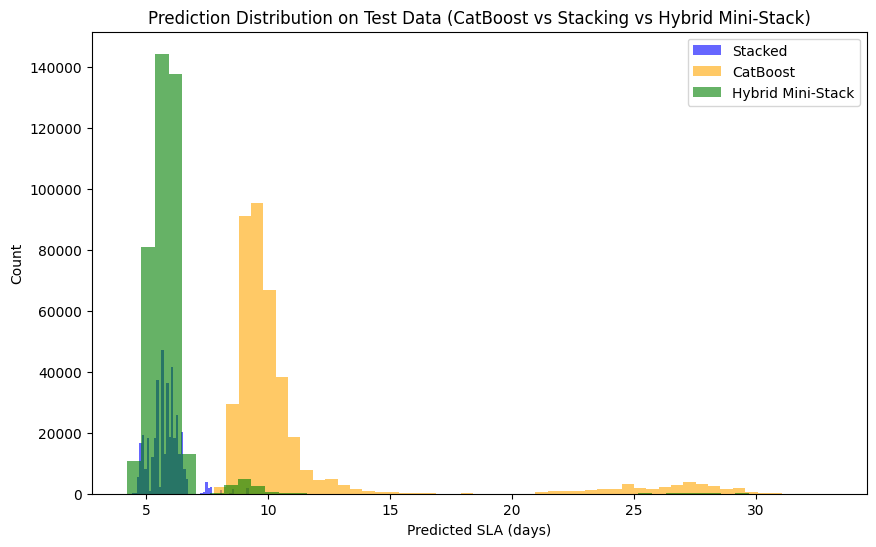

In [64]:
import matplotlib.pyplot as plt
import pandas as pd

# Load the test data that was used for predictions (from Step 4)
try:
    test_with_predictions = pd.read_csv("test_step4_ready.csv")
except FileNotFoundError:
    print("Error: 'test_step4_ready.csv' not found. Please run Step 4 first.")
    raise

# Define target to exclude from features
target = "order_delivery_sla"
features = [c for c in test_with_predictions.columns if c not in ["id", target]]

X_test = test_with_predictions[features]

# Get predictions using the defined function
try:
    preds = predict_with_models(X_test)
except NameError:
    print("Error: 'predict_with_models' function or necessary models not found.")
    raise

# Add predictions to the DataFrame for plotting
test_with_predictions["catboost_only"]     = preds["catboost_only"]
test_with_predictions["stacked_model"]     = preds["stacked_model"]
test_with_predictions["hybrid_mini_stack"] = preds["hybrid_mini_stack"]

# ----------------------------
# Plot the distributions
# ----------------------------
plt.figure(figsize=(10, 6))
plt.hist(test_with_predictions["stacked_model"], bins=50, alpha=0.6, label="Stacked", color="blue")
plt.hist(test_with_predictions["catboost_only"], bins=50, alpha=0.6, label="CatBoost", color="orange")
plt.hist(test_with_predictions["hybrid_mini_stack"], bins=50, alpha=0.6, label="Hybrid Mini-Stack", color="green")

plt.legend()
plt.xlabel("Predicted SLA (days)")
plt.ylabel("Count")
plt.title("Prediction Distribution on Test Data (CatBoost vs Stacking vs Hybrid Mini-Stack)")
plt.show()


In [57]:
test.head(20)

id  courier_partner_id  account_type_id  quantity  Pickup_Lat  \
0   428365149                   3             2520         1   28.446796   
1   428365152                   3             2520         1   28.446796   
2   428365154                   3             2520         1   28.446796   
3   428365156                   3             2520         1   28.446796   
4   428365161                   3             2520         1   28.446796   
5   428365163                   3             2520         1   28.446796   
6   428365165                   3             2520         1   28.446796   
7   428365168                   3             2520         1   28.446796   
8   428365172                   3             2520         1   28.446796   
9   428365254               30218            34291         1   28.446796   
10  428365262               30218            34291         1   28.446796   
11  428365276               30218            34291         1   28.446796   
12  428365964                   5             2515         1   28.446796   
13  428365968                   5             2515         1   28.446796   
14  428365971                   5             2515         1   28.446796   
15  428365974                   5             2515         1   28.446796   
16  428365976                   5             2515         1   28.446796   
17  428365979                   5             2515         1   28.446796   
18  428365981                   5             2515         1   28.446796   
19  428365985                   5             2515         1   28.446796   

    Pickup_Lon   Drop_Lat   Drop_Lon  drop_missing_flag  distance_km  ...  \
0    76.825692  28.355270  79.419900                  0   253.942450  ...   
1    76.825692  27.551256  79.343696                  0   266.511524  ...   
2    76.825692  30.336028  76.394597                  0   214.183846  ...   
3    76.825692  28.717775  77.772386                  0    97.225239  ...   
4    76.825692  26.100000  74.320000                  0   359.731771  ...   
5    76.825692  22.750651  78.510000                  1   655.485619  ...   
6    76.825692  29.534778  75.032083                  0   212.287781  ...   
7    76.825692  26.268382  78.217876                  0   278.520905  ...   
8    76.825692  28.990255  79.385452                  0   256.824136  ...   
9    76.825692  26.895278  75.825000                  0   198.679567  ...   
10   76.825692  28.462000  77.031639                  0    20.204674  ...   
11   76.825692  28.462000  77.031639                  0    20.204674  ...   
12   76.825692  22.344300  88.210400                  0  1328.680235  ...   
13   76.825692  22.540555  88.286389                  0  1323.512413  ...   
14   76.825692  22.406000  88.163750                  0  1320.922734  ...   
15   76.825692  18.511528  73.878250                  0  1144.762442  ...   
16   76.825692  13.101528  80.252194                  0  1742.792685  ...   
17   76.825692  19.042296  73.094345                  0  1112.327616  ...   
18   76.825692  16.732552  80.307755                  0  1350.475750  ...   
19   76.825692  12.963569  80.172347                  0  1756.191995  ...   

    zero_distance  dist_div_by_courier_median  courier_partner_id_le  \
0               0                    0.739402                      1   
1               0                    0.776000                      1   
2               0                    0.623638                      1   
3               0                    0.283090                      1   
4               0                    1.047429                      1   
5               0                    1.908573                      1   
6               0                    0.618117                      1   
7               0                    0.810967                      1   
8               0                    0.747793                      1   
9               0                    5.212381                      2   
10  

In [65]:
# --- Update prediction function to include Hybrid Mini-Stack ---
def predict_with_models(X_test, late_threshold=7):
    """
    Generate predictions from:
      1. CatBoost (single best base model)
      2. Stacking Meta-Model
      3. Hybrid Mini-Stack (best performing)
    """

    # --- 1. CatBoost ---
    cat_pred = loaded_cat.predict(X_test)

    # --- 2. Base models for stacking ---
    rf_pred  = loaded_rf.predict(X_test)
    lgb_pred = loaded_lgb.predict(X_test)
    xgb_pred = loaded_xgb.predict(xgb.DMatrix(X_test))
    cat_pred_for_stack = loaded_cat.predict(X_test)

    # Input to meta-model
    stack_input = np.column_stack([rf_pred, lgb_pred, xgb_pred, cat_pred_for_stack])

    # --- 3. Meta-model prediction ---
    stacked_pred = loaded_meta.predict(stack_input)

    # --- 4. Hybrid Mini-Stack ---
    hybrid_pred = np.zeros(len(cat_pred))

    # Normal vs long SLA split
    normal_mask = stacked_pred <= late_threshold
    long_mask   = ~normal_mask

    # Normal SLA → use Stacking
    hybrid_pred[normal_mask] = stacked_pred[normal_mask]

    # Long SLA → use CatBoost (robust tail predictions)
    hybrid_pred[long_mask] = cat_pred[long_mask]

    return {
        "catboost_only": cat_pred,
        "stacked_model": stacked_pred,
        "hybrid_mini_stack": hybrid_pred
    }


# --- Get predictions ---
preds = predict_with_models(X_test)

# Add hybrid predictions as final submission column
test["predicted_exact_sla"] = preds["hybrid_mini_stack"]

# Save submission file
submission = test[["id", "predicted_exact_sla"]].copy()
submission["predicted_exact_sla"] = submission["predicted_exact_sla"].clip(lower=0)

submission.to_csv("submission.csv", index=False)
print("submission.csv generated successfully using Hybrid Mini-Stack ✅")


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


submission.csv generated successfully using Hybrid Mini-Stack ✅


In [66]:
sm = pd.read_csv("submission.csv")

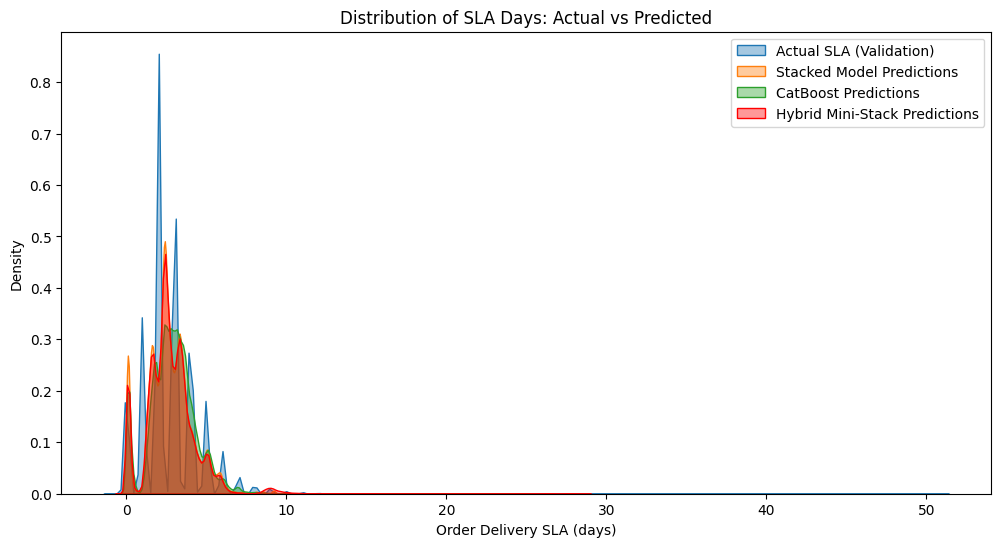

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


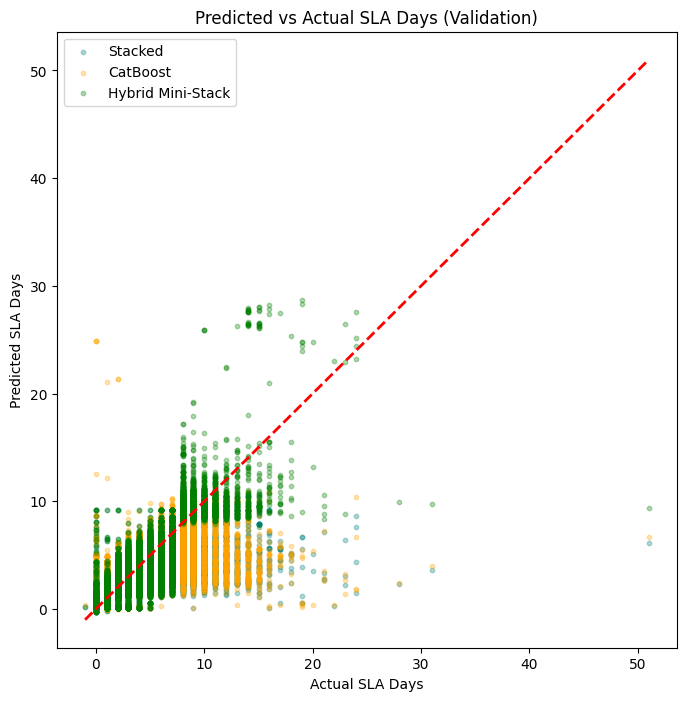

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# 1. Plot distribution of predictions vs actuals
# -----------------------------
plt.figure(figsize=(12,6))

# Actual validation target
sns.kdeplot(y_val, label="Actual SLA (Validation)", fill=True, alpha=0.4)

# Stacked model predictions
sns.kdeplot(stack_preds, label="Stacked Model Predictions", fill=True, alpha=0.4)

# CatBoost predictions
sns.kdeplot(val_cat, label="CatBoost Predictions", fill=True, alpha=0.4)

# Hybrid Mini-Stack predictions
sns.kdeplot(hybrid_preds, label="Hybrid Mini-Stack Predictions", fill=True, alpha=0.4, color="red")

plt.title("Distribution of SLA Days: Actual vs Predicted")
plt.xlabel("Order Delivery SLA (days)")
plt.ylabel("Density")
plt.legend()
plt.show()


# -----------------------------
# 2. Scatter plot: Predicted vs Actual (validation)
# -----------------------------
plt.figure(figsize=(8,8))

# Stacked model
plt.scatter(y_val, stack_preds, alpha=0.3, s=10, color="teal", label="Stacked")

# CatBoost
plt.scatter(y_val, val_cat, alpha=0.3, s=10, color="orange", label="CatBoost")

# Hybrid Mini-Stack
plt.scatter(y_val, hybrid_preds, alpha=0.3, s=10, color="green", label="Hybrid Mini-Stack")

# y = x line
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], "r--", lw=2)

plt.xlabel("Actual SLA Days")
plt.ylabel("Predicted SLA Days")
plt.title("Predicted vs Actual SLA Days (Validation)")
plt.legend()
plt.show()


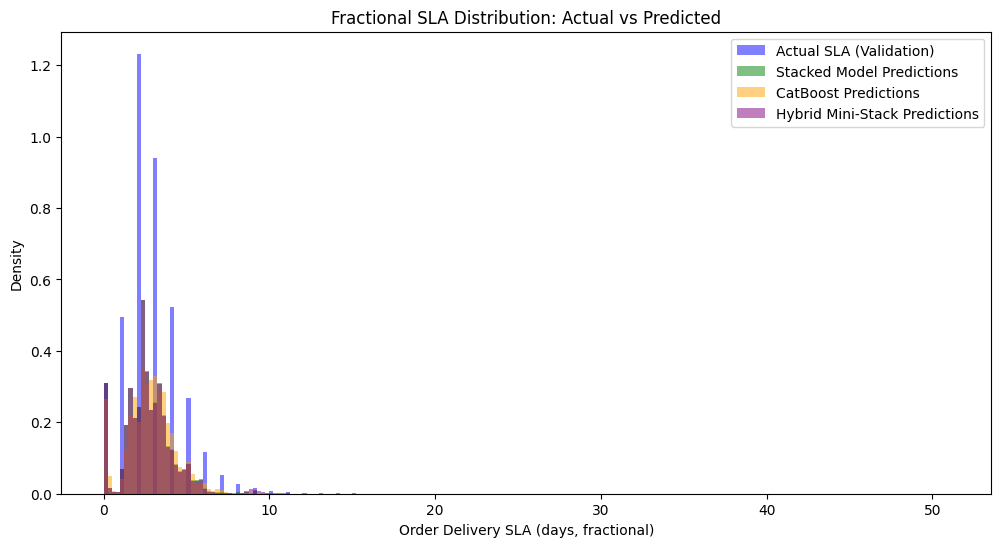

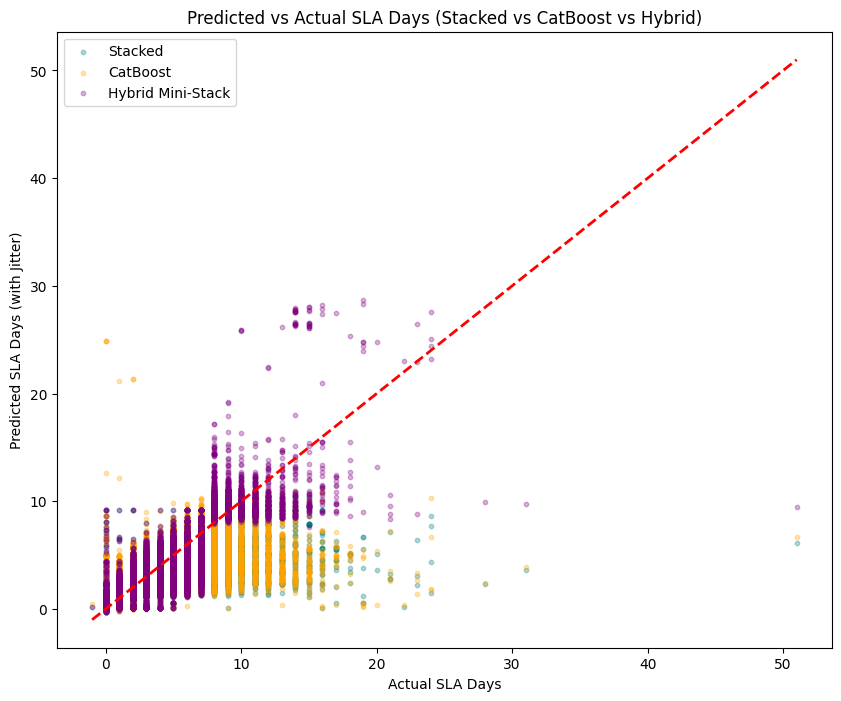

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# -----------------------------
# 1. Create bins for fractional SLA (e.g., 0.0–0.5, 0.5–1.0, ...)
# -----------------------------
bin_width = 0.25
bins = np.arange(0, max(y_val.max(), stack_preds.max(), hybrid_preds.max()) + bin_width, bin_width)

# -----------------------------
# 2. Plot histograms of actual vs predicted
# -----------------------------
plt.figure(figsize=(12,6))

plt.hist(y_val, bins=bins, alpha=0.5, label="Actual SLA (Validation)", color="blue", density=True)
plt.hist(stack_preds, bins=bins, alpha=0.5, label="Stacked Model Predictions", color="green", density=True)
plt.hist(val_cat, bins=bins, alpha=0.5, label="CatBoost Predictions", color="orange", density=True)
plt.hist(hybrid_preds, bins=bins, alpha=0.5, label="Hybrid Mini-Stack Predictions", color="purple", density=True)

plt.xlabel("Order Delivery SLA (days, fractional)")
plt.ylabel("Density")
plt.title("Fractional SLA Distribution: Actual vs Predicted")
plt.legend()
plt.show()


# -----------------------------
# 3. Scatter plot with jitter for better visibility
# -----------------------------
plt.figure(figsize=(10,8))

# Stacked predictions
plt.scatter(y_val, stack_preds + np.random.uniform(-0.02, 0.02, size=len(stack_preds)),
            alpha=0.3, s=10, color="teal", label="Stacked")

# CatBoost predictions
plt.scatter(y_val, val_cat + np.random.uniform(-0.02, 0.02, size=len(val_cat)),
            alpha=0.3, s=10, color="orange", label="CatBoost")

# Hybrid Mini-Stack predictions
plt.scatter(y_val, hybrid_preds + np.random.uniform(-0.02, 0.02, size=len(hybrid_preds)),
            alpha=0.3, s=10, color="purple", label="Hybrid Mini-Stack")

# y=x reference line
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], "r--", lw=2)

plt.xlabel("Actual SLA Days")
plt.ylabel("Predicted SLA Days (with Jitter)")
plt.title("Predicted vs Actual SLA Days (Stacked vs CatBoost vs Hybrid)")
plt.legend()
plt.show()


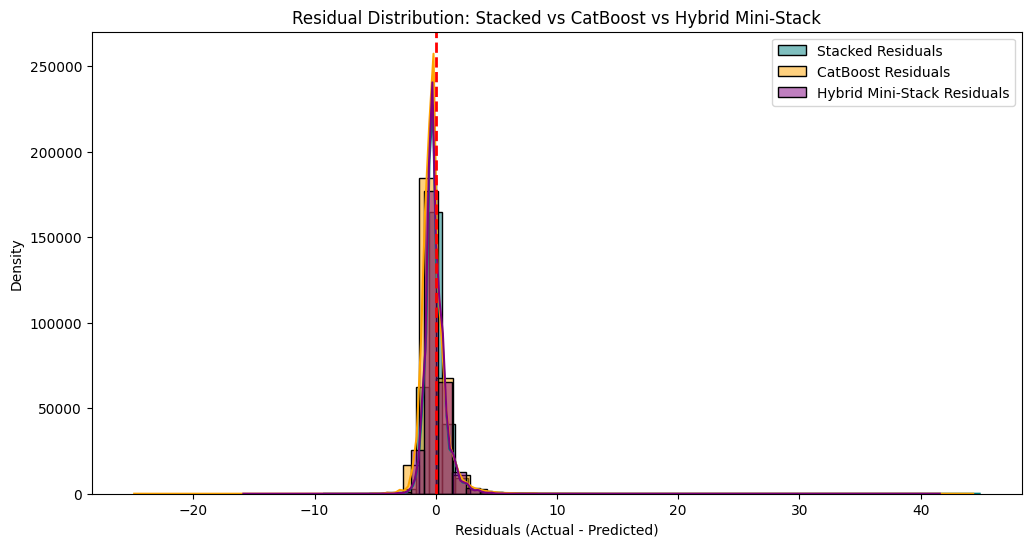

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# Residuals calculation
# -----------------------------
residuals_stack   = y_val - stack_preds
residuals_cat     = y_val - val_cat
residuals_hybrid  = y_val - hybrid_preds

# -----------------------------
# Residuals histogram
# -----------------------------
plt.figure(figsize=(12,6))

sns.histplot(residuals_stack, bins=50, kde=True, color="teal", label="Stacked Residuals", alpha=0.5)
sns.histplot(residuals_cat, bins=50, kde=True, color="orange", label="CatBoost Residuals", alpha=0.5)
sns.histplot(residuals_hybrid, bins=50, kde=True, color="purple", label="Hybrid Mini-Stack Residuals", alpha=0.5)

plt.axvline(0, color="red", linestyle="--", lw=2)  # zero-error reference line
plt.xlabel("Residuals (Actual - Predicted)")
plt.ylabel("Density")
plt.title("Residual Distribution: Stacked vs CatBoost vs Hybrid Mini-Stack")
plt.legend()
plt.show()


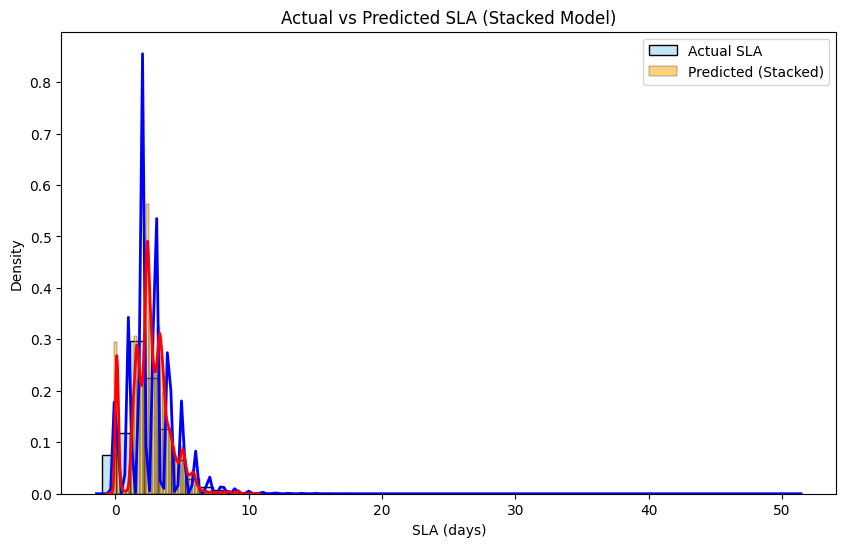

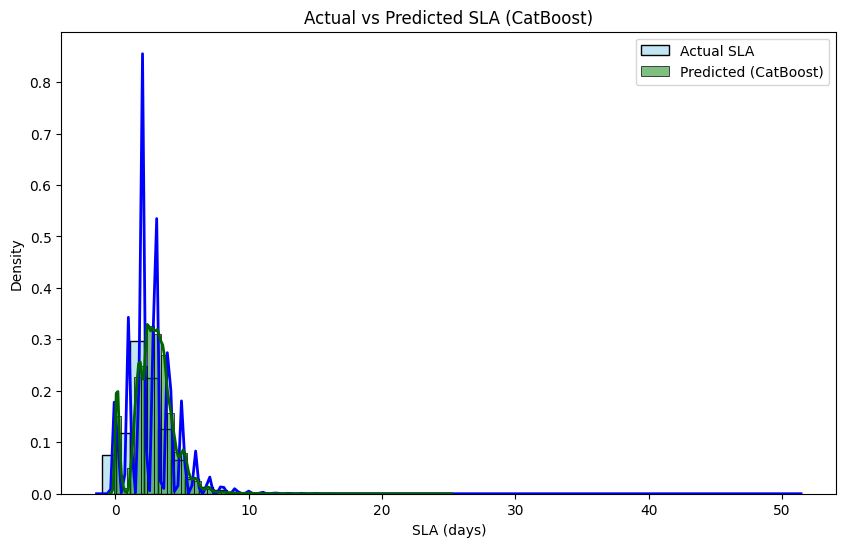

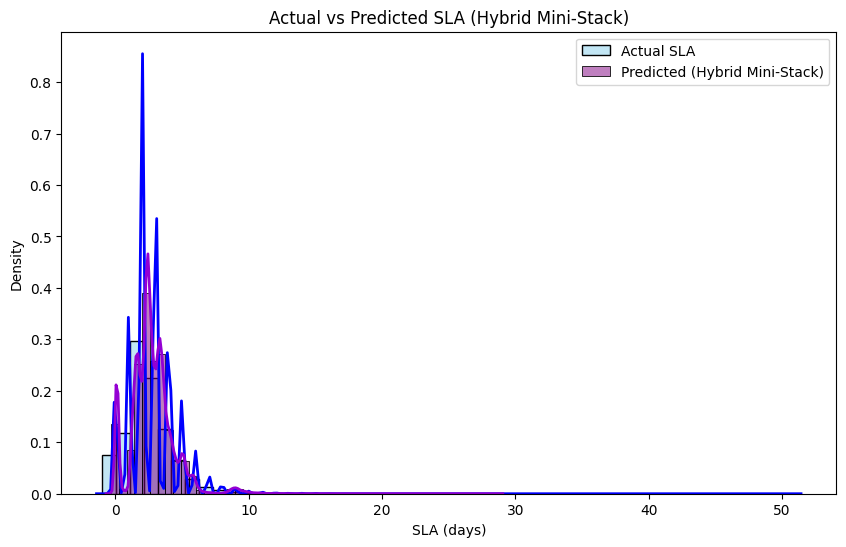

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# -----------------------------
# Prepare DataFrame
# -----------------------------
df_sla = pd.DataFrame({
    "Actual": y_val,
    "Predicted_Stacked": stack_preds,
    "Predicted_CatBoost": val_cat,
    "Predicted_Hybrid": hybrid_preds
})

# -----------------------------
# 1. Combined density + histogram: Stacked Model
# -----------------------------
plt.figure(figsize=(10,6))
sns.histplot(df_sla["Actual"], color="skyblue", label="Actual SLA", bins=50, alpha=0.5, stat="density")
sns.histplot(df_sla["Predicted_Stacked"], color="orange", label="Predicted (Stacked)", bins=50, alpha=0.5, stat="density")
sns.kdeplot(df_sla["Actual"], color="blue", lw=2)
sns.kdeplot(df_sla["Predicted_Stacked"], color="red", lw=2)
plt.xlabel("SLA (days)")
plt.ylabel("Density")
plt.title("Actual vs Predicted SLA (Stacked Model)")
plt.legend()
plt.show()

# -----------------------------
# 2. Combined density + histogram: CatBoost
# -----------------------------
plt.figure(figsize=(10,6))
sns.histplot(df_sla["Actual"], color="skyblue", label="Actual SLA", bins=50, alpha=0.5, stat="density")
sns.histplot(df_sla["Predicted_CatBoost"], color="green", label="Predicted (CatBoost)", bins=50, alpha=0.5, stat="density")
sns.kdeplot(df_sla["Actual"], color="blue", lw=2)
sns.kdeplot(df_sla["Predicted_CatBoost"], color="darkgreen", lw=2)
plt.xlabel("SLA (days)")
plt.ylabel("Density")
plt.title("Actual vs Predicted SLA (CatBoost)")
plt.legend()
plt.show()

# -----------------------------
# 3. Combined density + histogram: Hybrid Mini-Stack
# -----------------------------
plt.figure(figsize=(10,6))
sns.histplot(df_sla["Actual"], color="skyblue", label="Actual SLA", bins=50, alpha=0.5, stat="density")
sns.histplot(df_sla["Predicted_Hybrid"], color="purple", label="Predicted (Hybrid Mini-Stack)", bins=50, alpha=0.5, stat="density")
sns.kdeplot(df_sla["Actual"], color="blue", lw=2)
sns.kdeplot(df_sla["Predicted_Hybrid"], color="darkviolet", lw=2)
plt.xlabel("SLA (days)")
plt.ylabel("Density")
plt.title("Actual vs Predicted SLA (Hybrid Mini-Stack)")
plt.legend()
plt.show()


In [74]:
sm.head(20)

id  predicted_exact_sla
0   428365149             5.073088
1   428365152             5.073088
2   428365154             5.437910
3   428365156             5.842533
4   428365161             5.437910
5   428365163             5.437910
6   428365165             5.647544
7   428365168             5.437910
8   428365172             4.795733
9   428365254             5.647984
10  428365262             5.364714
11  428365276             5.364714
12  428365964             5.699803
13  428365968             5.700925
14  428365971             5.690111
15  428365974             5.830698
16  428365976             5.699803
17  428365979             5.800716
18  428365981             4.746186
19  428365985             5.699803

from matplotlib import pyplot as plt
_df_0['id'].plot(kind='hist', bins=20, title='id')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['predicted_exact_sla'].plot(kind='hist', bins=20, title='predicted_exact_sla')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2.plot(kind='scatter', x='id', y='predicted_exact_sla', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['id']
  ys = series['predicted_exact_sla']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_3.sort_values('id', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('id')
_ = plt.ylabel('predicted_exact_sla')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['id']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'id'}, axis=1)
              .sort_values('id', ascending=True))
  xs = counted['id']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_4.sort_values('id', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('id')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_5['id'].plot(kind='line', figsize=(8, 4), title='id')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_6['predicted_exact_sla'].plot(kind='line', figsize=(8, 4), title='predicted_exact_sla')
plt.gca().spines[['top', 'right']].set_visible(False)